In [14]:
import numpy as np
from utils import canny, load_fer2013_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Linear models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

# Tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# SVM models
from sklearn.svm import LinearSVC, SVC

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from skimage.feature import hog , local_binary_pattern 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import cv2
from facenet_pytorch import MTCNN
import lz4 


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 

from utils import EmotionDataPreprocessor   

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
import json
from datetime import datetime

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [ ]:
# 1. Load data (train split into train/val, and test)
print("📊 Loading data...")
# Load original training data
X_train_full, y_train_full, emotion_labels = load_fer2013_data('data/train')
# Load test data
X_test, y_test, _ = load_fer2013_data('data/test')

# Split train into train and validation (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=y_train_full  # Maintain class distribution
)

print(f"✅ Data loaded and split successfully!")
print(f"   Original train samples: {len(X_train_full)}")
print(f"   New train samples: {len(X_train)} ({len(X_train)/len(X_train_full)*100:.1f}%)")
print(f"   Validation samples: {len(X_val)} ({len(X_val)/len(X_train_full)*100:.1f}%)")
print(f"   Test samples: {len(X_test)}")

📊 Loading data...
Loading and preprocessing images...
Processing angry: 3995 images


Loading angry: 100%|██████████| 3995/3995 [00:24<00:00, 161.20it/s]


Processing disgust: 436 images


Loading disgust: 100%|██████████| 436/436 [00:02<00:00, 185.09it/s]



Processing fear: 4097 images


Loading fear: 100%|██████████| 4097/4097 [00:24<00:00, 166.88it/s]



Processing happy: 7215 images


Loading happy: 100%|██████████| 7215/7215 [00:42<00:00, 168.85it/s]



Processing sad: 4830 images


Loading sad: 100%|██████████| 4830/4830 [00:32<00:00, 150.29it/s]


Processing surprise: 3171 images


Loading surprise: 100%|██████████| 3171/3171 [00:20<00:00, 152.97it/s]



Processing neutral: 4965 images


Loading neutral: 100%|██████████| 4965/4965 [00:28<00:00, 174.66it/s]



Loading and preprocessing images...
Processing angry: 30 images


Loading angry: 100%|██████████| 30/30 [00:00<00:00, 174.03it/s]


Processing disgust: 30 images


Loading disgust: 100%|██████████| 30/30 [00:00<00:00, 177.25it/s]


Processing fear: 30 images


Loading fear: 100%|██████████| 30/30 [00:00<00:00, 172.33it/s]


Processing happy: 30 images


Loading happy: 100%|██████████| 30/30 [00:00<00:00, 170.20it/s]


Processing sad: 30 images


Loading sad: 100%|██████████| 30/30 [00:00<00:00, 196.41it/s]


Processing surprise: 30 images


Loading surprise: 100%|██████████| 30/30 [00:00<00:00, 198.20it/s]


Processing neutral: 30 images


Loading neutral: 100%|██████████| 30/30 [00:00<00:00, 298.03it/s]


Loading and preprocessing images...
Processing angry: 958 images


Loading angry: 100%|██████████| 958/958 [00:06<00:00, 153.62it/s]


Processing disgust: 111 images


Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 182.32it/s]


Processing fear: 1024 images


Loading fear: 100%|██████████| 1024/1024 [00:06<00:00, 151.73it/s]


Processing happy: 1774 images


Loading happy: 100%|██████████| 1774/1774 [00:12<00:00, 138.10it/s]


Processing sad: 1247 images


Loading sad: 100%|██████████| 1247/1247 [00:08<00:00, 140.25it/s]


Processing surprise: 831 images


Loading surprise: 100%|██████████| 831/831 [00:05<00:00, 147.82it/s]


Processing neutral: 1233 images


Loading neutral: 100%|██████████| 1233/1233 [00:07<00:00, 157.21it/s]



In [4]:

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Emotion labels: {emotion_labels}")
preprocessor = EmotionDataPreprocessor(
    target_size=(64, 64),
    random_state=42
)

X_train_processed, train_info = preprocessor.fit_transform(
    X_train,
    pca_variance=0.95  
)

X_val_processed, val_info = preprocessor.transform(X_val)




Training set: (28709, 48, 48)
Validation set: (210, 48, 48)
Test set: (7178, 48, 48)
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

🚀 TRAINING DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 28709/28709 [00:00<00:00, 157788.54it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 28709/28709 [00:00<00:00, 29631.37it/s]




[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 28709/28709 [00:00<00:00, 167850.50it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 28709/28709 [00:26<00:00, 1075.93it/s]



    HOG shape: (28709, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP: 100%|██████████| 28709/28709 [00:43<00:00, 664.08it/s]



    LBP shape: (28709, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 28709/28709 [00:39<00:00, 725.16it/s]



    SIFT shape: (28709, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (28709, 3684)
    - HOG: 1764 features
    - LBP: 640 features
    - SIFT: 1280 features
    - Total: 3684 features

[8/8] Standard Scaling and PCA
  → Fitting StandardScaler...
  → Combined shape: (28709, 3684)
    - HOG: 1764 features
    - LBP: 640 features
    - SIFT: 1280 features
    - Total: 3684 features

[8/8] Standard Scaling and PCA
  → Fitting StandardScaler...
  → Fitting PCA (variance=0.95)...
  → Fitting PCA (variance=0.95)...
    PCA reduced: 3684 → 1614 features
    Explained variance: 0.9500
    Number of components: 1614

✅ TRAINING PREPROCESSING COMPLETED
Final shape: (28709, 1614)
Original samples: 28709

🔄 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...
    PCA reduced: 3684 → 1614 features
    Explained variance: 0.9500
    Number of components: 1614

✅ TRAINING PREPROCESSING COMPLETED
Final shape: (28709, 1614)
Original samples: 2870

Median Filter: 100%|██████████| 210/210 [00:00<00:00, 104970.07it/s]



[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 210/210 [00:00<00:00, 24747.94it/s]




[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 210/210 [00:00<00:00, 206907.17it/s]



[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 210/210 [00:00<00:00, 1084.54it/s]


    HOG shape: (210, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/210 [00:00<?, ?it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP:  33%|███▎      | 70/210 [00:00<00:00, 699.98it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 210/210 [00:00<00:00, 690.88it/s]


    LBP shape: (210, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 210/210 [00:00<00:00, 810.92it/s]

    SIFT shape: (210, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (210, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

✅ TEST PREPROCESSING COMPLETED
Final shape: (210, 1614)
Original samples: 210


# Logistic Regression 

In [4]:
# Setup MLflow
mlflow.set_experiment("Emotion_Classification_Logistic_Regression")
mlflow.set_tracking_uri("file:./mlruns")  # Store locally in ./mlruns folder

print("="*70)
print("🔬 MLFLOW EXPERIMENT SETUP")
print("="*70)
print(f"Experiment: Emotion_Classification_Logistic_Regression")
print(f"Tracking URI: ./mlruns")
print(f"MLflow UI: Run 'mlflow ui' in terminal to view results")
print("="*70)

🔬 MLFLOW EXPERIMENT SETUP
Experiment: Emotion_Classification_Logistic_Regression
Tracking URI: ./mlruns
MLflow UI: Run 'mlflow ui' in terminal to view results



📝 STEP 1: BASELINE MODEL TRAINING

🔧 Training baseline model...
   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced

🔧 Training baseline model...
   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced


d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   19.8s finished


✅ Training completed!

📊 Training Set Performance:
   ROC-AUC (macro):     0.8601
   Accuracy:            0.5198
   F1-Score (macro):    0.5672
   F1-Score (weighted): 0.5172

📊 Validation Set Performance:
   ROC-AUC (macro):     0.8864
   Accuracy:            0.5714
   F1-Score (macro):    0.5615
   F1-Score (weighted): 0.5615

📋 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.4211    0.2667    0.3265        30
     disgust     1.0000    1.0000    1.0000        30
        fear     0.5556    0.5000    0.5263        30
       happy     0.4000    0.6000    0.4800        30
         sad     0.5000    0.6000    0.5455        30
    surprise     0.6286    0.7333    0.6769        30
     neutral     0.5000    0.3000    0.3750        30

    accuracy                         0.5714       210
   macro avg     0.5722    0.5714    0.5615       210
weighted avg     0.5722    0.5714    0.5615       210

   ROC-AUC (macro):     0.8601
   Ac

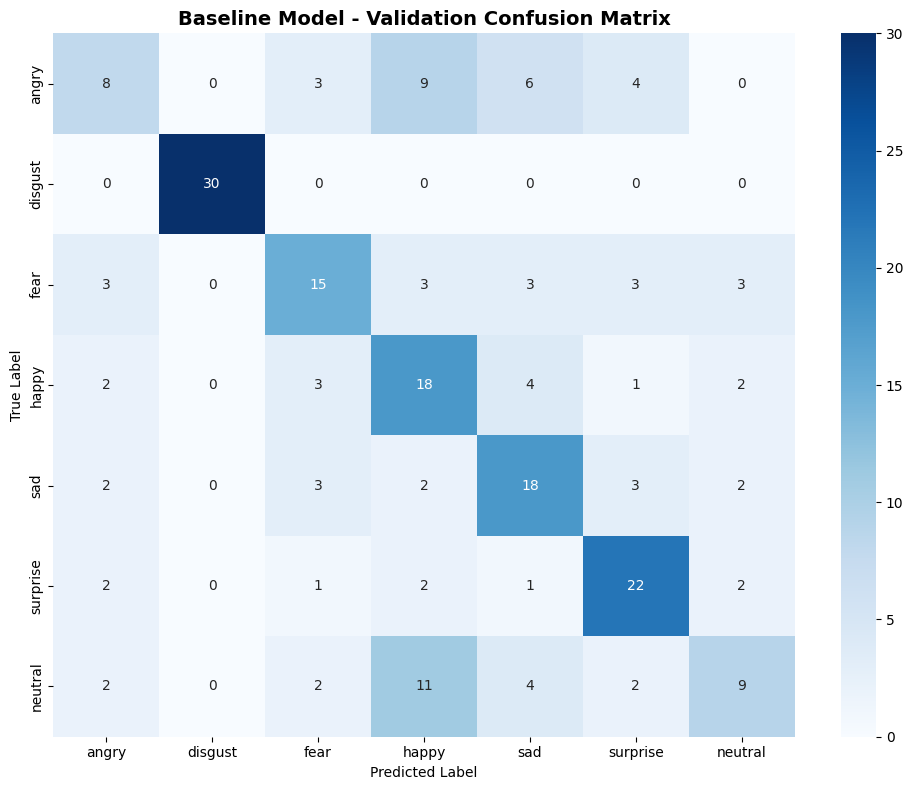

2025/11/05 16:06:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.




✅ BASELINE MODEL EVALUATION COMPLETED

🎯 Baseline Performance Summary:
   Training ROC-AUC:   0.8601
   Validation ROC-AUC: 0.8864
   Difference:         0.0263

📊 MLflow Run ID: 7929476706194e23926e4d24fb1ee7c9


In [5]:
# STEP 1: Train baseline model with default parameters
print("\n" + "="*70)
print("📝 STEP 1: BASELINE MODEL TRAINING")
print("="*70)

# Start MLflow run for baseline
with mlflow.start_run(run_name="baseline_logistic_regression"):
    
    # Log preprocessing parameters
    mlflow.log_params({
        "model_type": "LogisticRegression",
        "stage": "baseline",
        "target_size": str(preprocessor.target_size),
        "pca_variance": 0.95,
        "pca_components": preprocessor.pca.n_components_,
        "total_features": X_train_processed.shape[1],
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test)
    })
    
    baseline_model = LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        multi_class='ovr',
        n_jobs=-1,
        verbose=1
    )
    
    # Log model hyperparameters
    mlflow.log_params({
        "C": 1.0,
        "penalty": "l2",
        "solver": "lbfgs",
        "max_iter": 1000,
        "class_weight": "balanced",
        "multi_class": "ovr"
    })

    print("\n🔧 Training baseline model...")
    print(f"   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced")

    baseline_model.fit(X_train_processed, y_train)
    print("✅ Training completed!")

    # Evaluate on training set
    print("\n📊 Training Set Performance:")
    y_train_pred = baseline_model.predict(X_train_processed)
    y_train_pred_proba = baseline_model.predict_proba(X_train_processed)

    n_classes = len(emotion_labels)
    y_train_bin = label_binarize(y_train, classes=range(n_classes))

    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
    train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
    train_roc_auc = roc_auc_score(y_train_bin, y_train_pred_proba, average='macro', multi_class='ovr')

    print(f"   ROC-AUC (macro):     {train_roc_auc:.4f}")
    print(f"   Accuracy:            {train_accuracy:.4f}")
    print(f"   F1-Score (macro):    {train_f1_macro:.4f}")
    print(f"   F1-Score (weighted): {train_f1_weighted:.4f}")
    
    # Log training metrics
    mlflow.log_metrics({
        "train_roc_auc": train_roc_auc,
        "train_accuracy": train_accuracy,
        "train_f1_macro": train_f1_macro,
        "train_f1_weighted": train_f1_weighted
    })

    # Evaluate on validation set
    print("\n📊 Validation Set Performance:")
    y_val_pred = baseline_model.predict(X_val_processed)
    y_val_pred_proba = baseline_model.predict_proba(X_val_processed)

    y_val_bin = label_binarize(y_val, classes=range(n_classes))

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
    val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    val_roc_auc = roc_auc_score(y_val_bin, y_val_pred_proba, average='macro', multi_class='ovr')

    print(f"   ROC-AUC (macro):     {val_roc_auc:.4f}")
    print(f"   Accuracy:            {val_accuracy:.4f}")
    print(f"   F1-Score (macro):    {val_f1_macro:.4f}")
    print(f"   F1-Score (weighted): {val_f1_weighted:.4f}")
    
    # Log validation metrics
    mlflow.log_metrics({
        "val_roc_auc": val_roc_auc,
        "val_accuracy": val_accuracy,
        "val_f1_macro": val_f1_macro,
        "val_f1_weighted": val_f1_weighted
    })

    # Classification report
    print("\n📋 Validation Classification Report:")
    report = classification_report(y_val, y_val_pred, target_names=emotion_labels, digits=4, output_dict=True)
    print(classification_report(y_val, y_val_pred, target_names=emotion_labels, digits=4))
    
    # Log per-class metrics
    for emotion in emotion_labels:
        if emotion in report:
            mlflow.log_metrics({
                f"val_{emotion}_precision": report[emotion]['precision'],
                f"val_{emotion}_recall": report[emotion]['recall'],
                f"val_{emotion}_f1": report[emotion]['f1-score']
            })

    # Confusion matrix visualization
    cm_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Baseline Model - Validation Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Log confusion matrix as artifact
    cm_path = "baseline_confusion_matrix.png"
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path)
    plt.show()
    
    # Log model with signature
    signature = infer_signature(X_train_processed, baseline_model.predict(X_train_processed))
    mlflow.sklearn.log_model(
        baseline_model, 
        "model",
        signature=signature,
        input_example=X_train_processed[:5]
    )
    
    # Store baseline results
    baseline_results = {
        'train': {
            'roc_auc': train_roc_auc,
            'accuracy': train_accuracy,
            'f1_macro': train_f1_macro,
            'f1_weighted': train_f1_weighted
        },
        'validation': {
            'roc_auc': val_roc_auc,
            'accuracy': val_accuracy,
            'f1_macro': val_f1_macro,
            'f1_weighted': val_f1_weighted
        }
    }
    
    # Log baseline results as JSON artifact
    baseline_json = "baseline_results.json"
    with open(baseline_json, 'w') as f:
        json.dump(baseline_results, f, indent=4)
    mlflow.log_artifact(baseline_json)

    print("\n" + "="*70)
    print("✅ BASELINE MODEL EVALUATION COMPLETED")
    print("="*70)
    print(f"\n🎯 Baseline Performance Summary:")
    print(f"   Training ROC-AUC:   {train_roc_auc:.4f}")
    print(f"   Validation ROC-AUC: {val_roc_auc:.4f}")
    print(f"   Difference:         {abs(train_roc_auc - val_roc_auc):.4f}")
    
    # Log overfitting metric
    overfitting_gap = train_roc_auc - val_roc_auc
    mlflow.log_metric("overfitting_gap", overfitting_gap)
    
    if train_roc_auc - val_roc_auc > 0.05:
        print("   ⚠️  Warning: Possible overfitting detected!")
        mlflow.set_tag("overfitting_warning", "true")
    
    # Add tags
    mlflow.set_tag("model_stage", "baseline")
    mlflow.set_tag("dataset", "FER2013")
    mlflow.set_tag("feature_extraction", "HOG+LBP+SIFT")
    
    print(f"\n📊 MLflow Run ID: {mlflow.active_run().info.run_id}")

In [6]:
# STEP 2: Hyperparameter Tuning with GridSearchCV (Demo - 10 combinations)
print("\n" + "="*70)
print("🔍 STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*70)

from sklearn.model_selection import GridSearchCV

# Reduced hyperparameter grid for demo (max 10 combinations)
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000],
    'class_weight': ['balanced']
}

print(f"\n📋 Parameter Grid (Demo - Limited Combinations):")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver']) * len(param_grid['max_iter']) * len(param_grid['class_weight'])
print(f"\nTotal combinations to test: {total_combinations}")
print(f"Baseline ROC-AUC to beat: {val_roc_auc:.4f}\n")

# Create parent run for hyperparameter tuning
with mlflow.start_run(run_name="gridsearch_tuning_parent") as parent_run:
    
    mlflow.set_tag("stage", "hyperparameter_tuning")
    mlflow.set_tag("search_method", "GridSearchCV")
    mlflow.set_tag("total_combinations", total_combinations)
    mlflow.log_param("baseline_roc_auc", val_roc_auc)
    
    print("Starting GridSearchCV with MLflow tracking...\n")
    
    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42, multi_class='ovr', n_jobs=-1),
        param_grid=param_grid,
        cv=3,  # 3-fold cross-validation on training data
        scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )
    
    # Fit GridSearchCV
    print("🔧 Running GridSearchCV...")
    grid_search.fit(X_train_processed, y_train)
    print("✅ GridSearchCV completed!")
    
    # Get results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results.sort_values('rank_test_score')
    
    # Log all results as nested runs
    print("\n📊 Logging all configurations to MLflow...\n")
    
    results_list = []
    best_roc_auc = val_roc_auc
    best_model = baseline_model
    best_run_id = None
    
    for idx in range(len(cv_results)):
        row = cv_results.iloc[idx]
        
        with mlflow.start_run(run_name=f"grid_run_{idx+1}", nested=True):
            
            # Extract parameters
            params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
            
            # Log parameters
            mlflow.log_params({
                **{k: str(v) for k, v in params.items()},
                "model_type": "LogisticRegression",
                "stage": "tuning",
                "cv_rank": int(row['rank_test_score'])
            })
            
            # Train model with these parameters on full training set
            model = LogisticRegression(**params, random_state=42, multi_class='ovr', n_jobs=-1)
            model.fit(X_train_processed, y_train)
            
            # Evaluate on validation set
            y_val_pred = model.predict(X_val_processed)
            y_val_pred_proba = model.predict_proba(X_val_processed)
            
            # Calculate metrics
            roc_auc = roc_auc_score(y_val_bin, y_val_pred_proba, average='macro', multi_class='ovr')
            accuracy = accuracy_score(y_val, y_val_pred)
            f1_macro = f1_score(y_val, y_val_pred, average='macro')
            f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
            
            # Log metrics
            mlflow.log_metrics({
                "cv_mean_test_score": row['mean_test_score'],
                "cv_std_test_score": row['std_test_score'],
                "val_roc_auc": roc_auc,
                "val_accuracy": accuracy,
                "val_f1_macro": f1_macro,
                "val_f1_weighted": f1_weighted
            })
            
            # Store results
            result = {
                'run_id': mlflow.active_run().info.run_id,
                **params,
                'cv_mean_score': row['mean_test_score'],
                'cv_std_score': row['std_test_score'],
                'roc_auc': roc_auc,
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            }
            results_list.append(result)
            
            # Update best model
            if roc_auc > best_roc_auc:
                improvement = roc_auc - best_roc_auc
                best_roc_auc = roc_auc
                best_model = model
                best_run_id = mlflow.active_run().info.run_id
                best_params = params
                best_metrics = {
                    'val_roc_auc': roc_auc,
                    'val_accuracy': accuracy,
                    'val_f1_macro': f1_macro,
                    'val_f1_weighted': f1_weighted
                }
                
                # Mark as best run
                mlflow.set_tag("best_run", "true")
                
                # Log model for best run
                signature = infer_signature(X_train_processed, model.predict(X_train_processed))
                mlflow.sklearn.log_model(
                    model,
                    "model",
                    signature=signature
                )
                
                print(f"✨ New best model found! (+{improvement:.4f})")
                print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
                print(f"   CV Score: {row['mean_test_score']:.4f}")
                print(f"   Params: {params}")
                print(f"   MLflow Run ID: {best_run_id}\n")
    
    # Log summary metrics to parent run
    mlflow.log_metrics({
        "best_val_roc_auc": best_roc_auc,
        "best_cv_score": grid_search.best_score_,
        "total_combinations": total_combinations,
        "improvement_over_baseline": best_roc_auc - baseline_results['validation']['roc_auc']
    })
    
    # Log best parameters to parent run
    for key, value in best_params.items():
        mlflow.log_param(f"best_{key}", str(value))
    
    mlflow.set_tag("best_run_id", best_run_id)
    
    # Save CV results
    cv_results_path = "gridsearch_cv_results.csv"
    cv_results.to_csv(cv_results_path, index=False)
    mlflow.log_artifact(cv_results_path)

print("\n" + "="*70)
print("✅ GRIDSEARCHCV HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement = best_roc_auc - baseline_results['validation']['roc_auc']
print(f"\n🎯 Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {grid_search.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc:.4f}")
print(f"   Improvement:          {improvement:.4f} ({improvement/baseline_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Total combinations:   {total_combinations}")
print(f"\n📊 Best MLflow Run ID: {best_run_id}")


🔍 STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV

📋 Parameter Grid (Demo - Limited Combinations):
   C: [0.1, 1.0, 10.0]
   penalty: ['l2']
   solver: ['lbfgs', 'saga']
   max_iter: [1000]
   class_weight: ['balanced']

Total combinations to test: 6
Baseline ROC-AUC to beat: 0.8864

Starting GridSearchCV with MLflow tracking...

🔧 Running GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ GridSearchCV completed!

📊 Logging all configurations to MLflow...



d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site

✨ New best model found! (+0.0003)
   ROC-AUC: 0.8867 | Accuracy: 0.5714 | F1-Macro: 0.5615
   CV Score: 0.7276
   Params: {'C': np.float64(10.0), 'class_weight': 'balanced', 'max_iter': np.int64(1000), 'penalty': 'l2', 'solver': 'lbfgs'}
   MLflow Run ID: 76d918b039ed4f36ae47b58eac424a4b


✅ GRIDSEARCHCV HYPERPARAMETER TUNING COMPLETED

🎯 Tuning Results:
   Baseline ROC-AUC:     0.8864
   Best CV ROC-AUC:      0.7317
   Best Val ROC-AUC:     0.8867
   Improvement:          0.0003 (0.04%)
   Total combinations:   6

📊 Best MLflow Run ID: 76d918b039ed4f36ae47b58eac424a4b



📊 TOP 10 MODELS BY ROC-AUC:
                          run_id    C class_weight  max_iter penalty solver  cv_mean_score  cv_std_score  roc_auc  accuracy  f1_macro  f1_weighted
76d918b039ed4f36ae47b58eac424a4b 10.0     balanced      1000      l2  lbfgs       0.727557      0.001121 0.886720  0.571429  0.561461     0.561461
3c201125dfff4468bc14e091c7f9af38  1.0     balanced      1000      l2  lbfgs       0.730448      0.001525 0.886402  0.571429  0.561461     0.561461
ce52df7a3b814393a54ada680569bb62  0.1     balanced      1000      l2  lbfgs       0.731681      0.001950 0.885741  0.571429  0.561461     0.561461
fa09c5caf6604aecbf43cda5f1a68473 10.0     balanced      1000      l2   saga       0.729380      0.002143 0.885132  0.571429  0.561461     0.561461
d92dc0ff26c2492c819cddfb34274560  1.0     balanced      1000      l2   saga       0.729488      0.002145 0.885132  0.571429  0.561461     0.561461
334f7a2a5bef4d2c8fb07ac88363850f  0.1     balanced      1000      l2   saga       0.73044

C:\Users\LEGION\AppData\Local\Temp\ipykernel_15052\3990784168.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(penalty_comparison.values(), labels=penalty_comparison.keys())
C:\Users\LEGION\AppData\Local\Temp\ipykernel_15052\3990784168.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(solver_comparison.values(), labels=solver_comparison.keys())


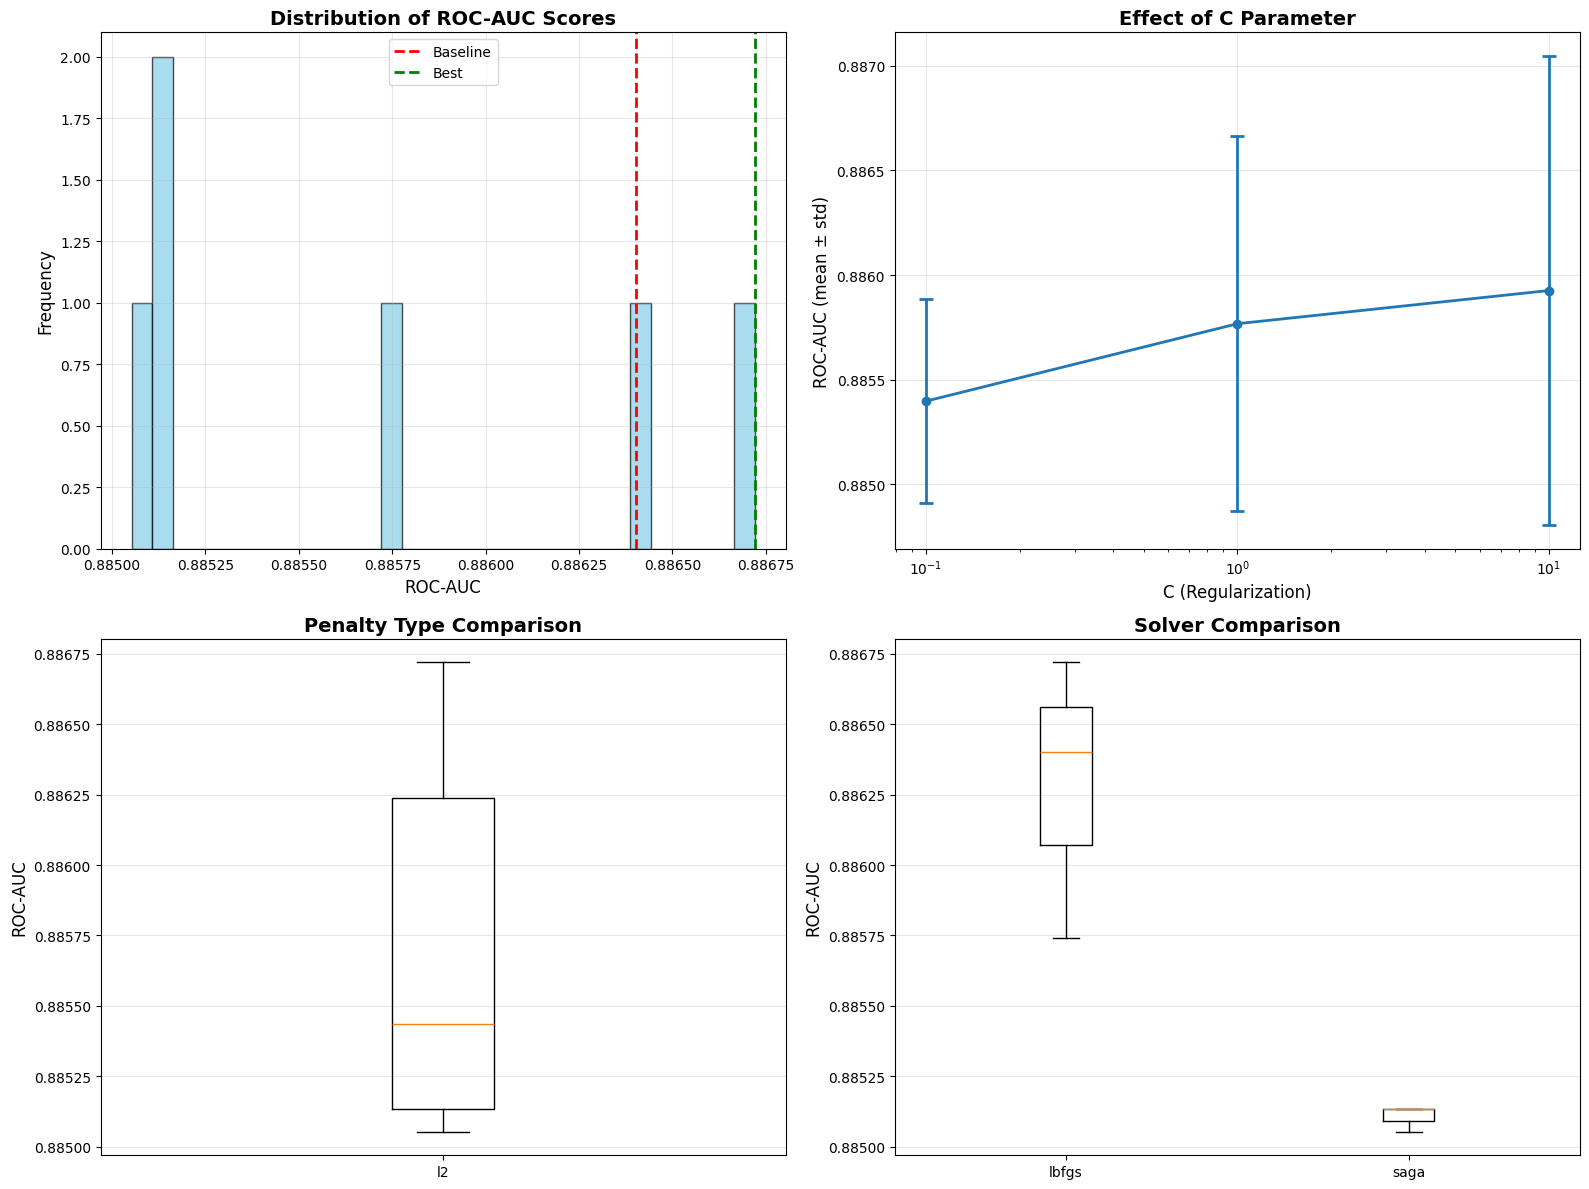


🏆 BEST MODEL PARAMETERS

Best Parameters:
  C: 10.0
  class_weight: balanced
  max_iter: 1000
  penalty: l2
  solver: lbfgs

Validation Metrics:
  val_roc_auc: 0.8867
  val_accuracy: 0.5714
  val_f1_macro: 0.5615
  val_f1_weighted: 0.5615


In [7]:
# Visualize tuning results and log to MLflow
with mlflow.start_run(run_name="tuning_visualization"):
    
    mlflow.set_tag("stage", "analysis")
    
    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values('roc_auc', ascending=False)

    print("\n📊 TOP 10 MODELS BY ROC-AUC:")
    print(results_df.head(10).to_string(index=False))
    
    # Save results to CSV and log as artifact
    results_csv = "tuning_results.csv"
    results_df.to_csv(results_csv, index=False)
    mlflow.log_artifact(results_csv)

    # Visualize tuning results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. ROC-AUC distribution
    ax1 = axes[0, 0]
    ax1.hist(results_df['roc_auc'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.axvline(baseline_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
    ax1.axvline(best_roc_auc, color='green', linestyle='--', linewidth=2, label='Best')
    ax1.set_xlabel('ROC-AUC', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of ROC-AUC Scores', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. C parameter effect
    ax2 = axes[0, 1]
    c_effect = results_df.groupby('C')['roc_auc'].agg(['mean', 'std']).reset_index()
    ax2.errorbar(c_effect['C'], c_effect['mean'], yerr=c_effect['std'], marker='o', capsize=5, capthick=2, linewidth=2)
    ax2.set_xscale('log')
    ax2.set_xlabel('C (Regularization)', fontsize=12)
    ax2.set_ylabel('ROC-AUC (mean ± std)', fontsize=12)
    ax2.set_title('Effect of C Parameter', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    # 3. Penalty comparison
    ax3 = axes[1, 0]
    penalty_comparison = results_df.groupby('penalty')['roc_auc'].apply(list).to_dict()
    ax3.boxplot(penalty_comparison.values(), labels=penalty_comparison.keys())
    ax3.set_ylabel('ROC-AUC', fontsize=12)
    ax3.set_title('Penalty Type Comparison', fontsize=14, fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    # 4. Solver comparison
    ax4 = axes[1, 1]
    solver_comparison = results_df.groupby('solver')['roc_auc'].apply(list).to_dict()
    ax4.boxplot(solver_comparison.values(), labels=solver_comparison.keys())
    ax4.set_ylabel('ROC-AUC', fontsize=12)
    ax4.set_title('Solver Comparison', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    
    # Log visualization as artifact
    tuning_viz_path = 'hyperparameter_tuning_analysis.png'
    plt.savefig(tuning_viz_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(tuning_viz_path)
    plt.show()

    print("\n" + "="*70)
    print("🏆 BEST MODEL PARAMETERS")
    print("="*70)
    print(f"\nBest Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    print(f"\nValidation Metrics:")
    for key, value in best_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    # Log summary statistics
    mlflow.log_metrics({
        "mean_roc_auc": results_df['roc_auc'].mean(),
        "std_roc_auc": results_df['roc_auc'].std(),
        "min_roc_auc": results_df['roc_auc'].min(),
        "max_roc_auc": results_df['roc_auc'].max()
    })


🎯 FINAL EVALUATION ON TEST SET

🔄 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 7178/7178 [00:00<00:00, 160860.84it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 7178/7178 [00:00<00:00, 28860.63it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 7178/7178 [00:00<00:00, 160314.35it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 7178/7178 [00:06<00:00, 1113.23it/s]


    HOG shape: (7178, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/7178 [00:00<?, ?it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 7178/7178 [00:11<00:00, 632.21it/s]


    LBP shape: (7178, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 7178/7178 [00:08<00:00, 889.36it/s]



    SIFT shape: (7178, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (7178, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...
  → Applying fitted PCA...

✅ TEST PREPROCESSING COMPLETED
Final shape: (7178, 1614)
Original samples: 7178

Test Set Metrics:
  ROC-AUC (macro):     0.7431
  Accuracy:            0.4104
  F1-Score (macro):    0.3776
  F1-Score (weighted): 0.4080

📋 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.2947    0.3079    0.3012       958
     disgust     0.2183    0.3874    0.2792       111
        fear     0.2705    0.2480    0.2588      1024
       happy     0.6124    0.5913    0.6017      1774
         sad     0.3080    0.2662    0.2856      1247
    surprise     0.4607    0.5993    0.5209       831
     neutral     0.4063    0.3852    0.3955      1233

    accuracy                         0.4104      7178
   macro avg     0.3673    0.3

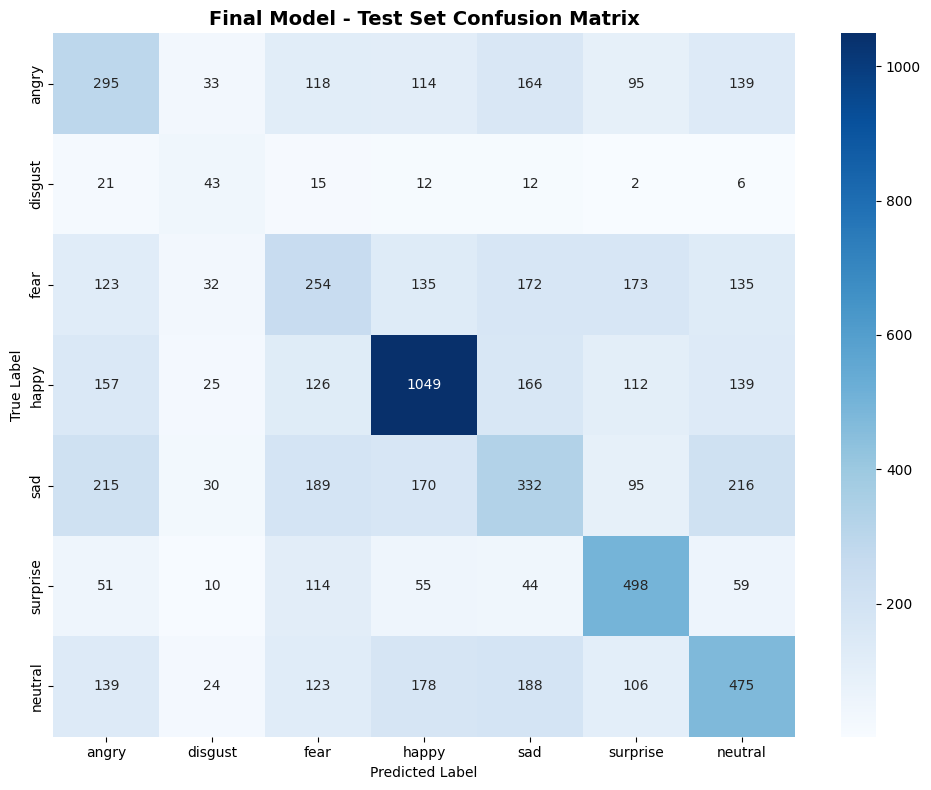

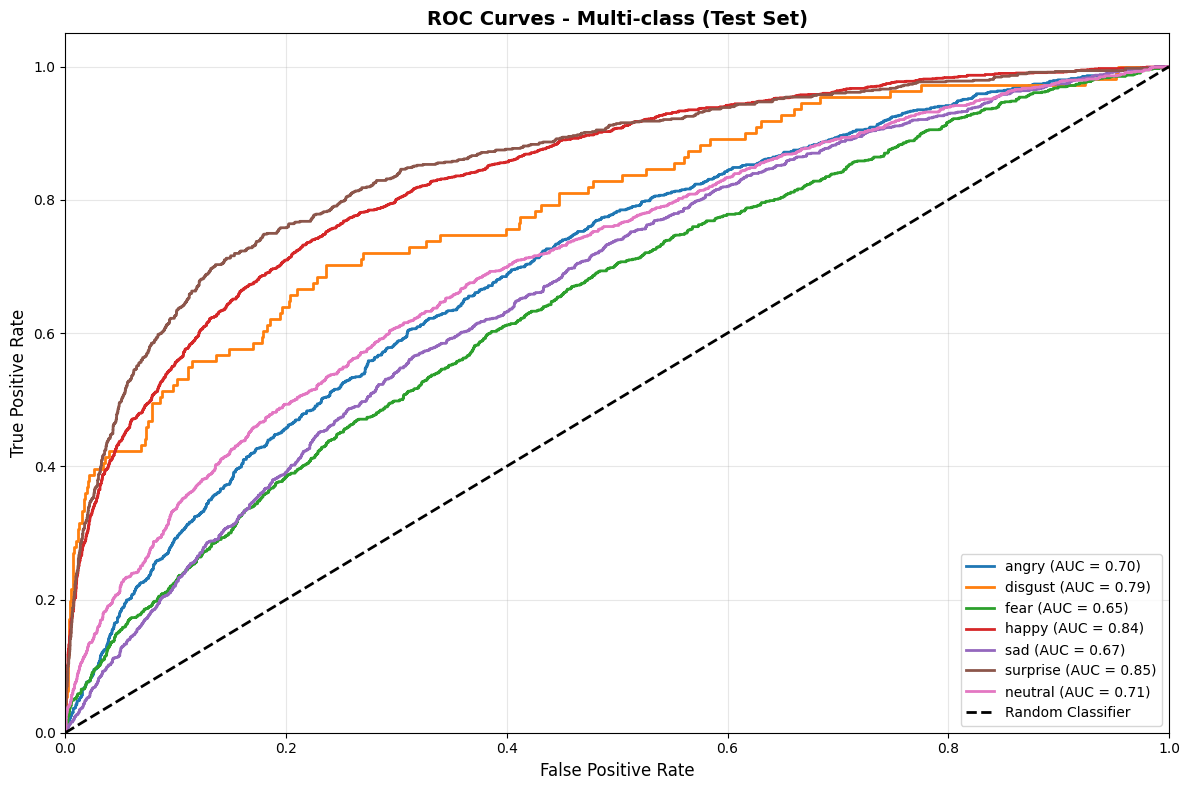

2025/11/05 16:57:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.294705 0.307933  0.301174      958
 disgust   0.218274 0.387387  0.279221      111
    fear   0.270501 0.248047  0.258788     1024
   happy   0.612376 0.591319  0.601663     1774
     sad   0.307978 0.266239  0.285591     1247
surprise   0.460685 0.599278  0.520921      831
 neutral   0.406330 0.385239  0.395504     1233

💾 Model saved: models/logistic_regression_best_20251105_165721.pkl
💾 Results saved: models/logistic_regression_results_20251105_165721.json

🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY

🎯 Final Test Performance:
  ROC-AUC:  0.7431
  Accuracy: 0.4104
  F1-Score: 0.3776

📊 MLflow Run ID: a649a960b1a14f6aa5038026fe5fee77
📂 Model saved as: models/logistic_regression_best_20251105_165721.pkl

💡 To view all experiments, run: mlflow ui
💾 Results saved: models/logistic_regression_results_20251105_165721.json

🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY

🎯 Final Test Performance:
  ROC-AUC:  0.743

Registered model 'Emotion_Classifier_LogisticRegression' already exists. Creating a new version of this model...
Created version '3' of model 'Emotion_Classifier_LogisticRegression'.


In [12]:
# Final evaluation on test set with MLflow tracking
print("\n" + "="*70)
print("🎯 FINAL EVALUATION ON TEST SET")
print("="*70)

with mlflow.start_run(run_name="final_test_evaluation"):
    
    mlflow.set_tag("stage", "final_evaluation")
    mlflow.set_tag("best_model_run_id", best_run_id)
    
    # Log best model parameters
    for key, value in best_params.items():
        mlflow.log_param(key, value)
    
    # Preprocess test data
    X_test_processed, test_info = preprocessor.transform(X_test)
    
    # Predict on test set
    y_test_pred = best_model.predict(X_test_processed)
    y_test_pred_proba = best_model.predict_proba(X_test_processed)
    
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    # Calculate all metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
    test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    test_roc_auc = roc_auc_score(y_test_bin, y_test_pred_proba, average='macro', multi_class='ovr')
    
    print(f"\nTest Set Metrics:")
    print(f"  ROC-AUC (macro):     {test_roc_auc:.4f}")
    print(f"  Accuracy:            {test_accuracy:.4f}")
    print(f"  F1-Score (macro):    {test_f1_macro:.4f}")
    print(f"  F1-Score (weighted): {test_f1_weighted:.4f}")
    
    # Log test metrics
    mlflow.log_metrics({
        "test_roc_auc": test_roc_auc,
        "test_accuracy": test_accuracy,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted
    })
    
    # Classification report
    print(f"\n📋 Test Classification Report:")
    report = classification_report(y_test, y_test_pred, target_names=emotion_labels, digits=4, output_dict=True)
    print(classification_report(y_test, y_test_pred, target_names=emotion_labels, digits=4))
    
    # Log per-class metrics
    for emotion in emotion_labels:
        if emotion in report:
            mlflow.log_metrics({
                f"test_{emotion}_precision": report[emotion]['precision'],
                f"test_{emotion}_recall": report[emotion]['recall'],
                f"test_{emotion}_f1": report[emotion]['f1-score']
            })
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Final Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Log confusion matrix
    test_cm_path = 'test_confusion_matrix.png'
    plt.savefig(test_cm_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(test_cm_path)
    plt.show()
    
    # ROC Curves for each class
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
        roc_auc_class = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
        
        # Log per-class AUC
        mlflow.log_metric(f"test_{emotion_labels[i]}_auc", roc_auc_class)

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Log ROC curves
    roc_path = 'test_roc_curves.png'
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(roc_path)
    plt.show()
    
    # Per-class metrics table
    print(f"\n📊 Per-Class Metrics:")
    class_metrics = []
    for i, emotion in enumerate(emotion_labels):
        precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
        recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics.append({
            'Emotion': emotion,
            'Precision': float(precision),
            'Recall': float(recall),
            'F1-Score': float(f1),
            'Support': int(cm[i, :].sum())
        })

    class_metrics_df = pd.DataFrame(class_metrics)
    print(class_metrics_df.to_string(index=False))
    
    # Save and log class metrics
    class_metrics_csv = "test_class_metrics.csv"
    class_metrics_df.to_csv(class_metrics_csv, index=False)
    mlflow.log_artifact(class_metrics_csv)
    
    # Save final model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f'models/logistic_regression_best_{timestamp}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"\n💾 Model saved: {model_filename}")
    mlflow.log_artifact(model_filename)
    
    # Log final model with signature
    signature = infer_signature(X_test_processed, best_model.predict(X_test_processed))
    mlflow.sklearn.log_model(
        best_model,
        "final_model",
        signature=signature,
        registered_model_name="Emotion_Classifier_LogisticRegression"
    )
    
    # Save complete results
    # Helper function to convert numpy types to native Python types
    def convert_to_native_types(obj):
        """Recursively convert numpy types to native Python types"""
        if isinstance(obj, dict):
            return {k: convert_to_native_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_native_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    final_results = {
        'model_name': 'Logistic Regression',
        'timestamp': timestamp,
        'best_params': convert_to_native_types(best_params),
        'best_run_id': best_run_id,
        'validation_metrics': convert_to_native_types(best_metrics),
        'test_metrics': {
            'roc_auc': float(test_roc_auc),
            'accuracy': float(test_accuracy),
            'f1_macro': float(test_f1_macro),
            'f1_weighted': float(test_f1_weighted)
        },
        'per_class_metrics': class_metrics,
        'training_samples': int(len(X_train)),
        'validation_samples': int(len(X_val)),
        'test_samples': int(len(X_test)),
        'feature_dimension': int(X_train_processed.shape[1]),
        'emotion_labels': emotion_labels
    }
    
    results_filename = f'models/logistic_regression_results_{timestamp}.json'
    with open(results_filename, 'w') as f:
        json.dump(final_results, f, indent=4)
    print(f"💾 Results saved: {results_filename}")
    mlflow.log_artifact(results_filename)
    
    # Add summary tags
    mlflow.set_tag("dataset", "FER2013")
    mlflow.set_tag("feature_extraction", "HOG+LBP+SIFT")
    mlflow.set_tag("model_family", "LogisticRegression")
    mlflow.set_tag("status", "production_ready")
    
    print("\n" + "="*70)
    print("🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY")
    print("="*70)
    print(f"\n🎯 Final Test Performance:")
    print(f"  ROC-AUC:  {test_roc_auc:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  F1-Score: {test_f1_macro:.4f}")
    print(f"\n📊 MLflow Run ID: {mlflow.active_run().info.run_id}")
    print(f"📂 Model saved as: {model_filename}")
    print(f"\n💡 To view all experiments, run: mlflow ui")

# Random forest

In [6]:
# Setup MLflow experiment for Random Forest
mlflow.set_experiment("Emotion_Classification_Random_Forest")

print("="*70)
print("🔬 MLFLOW EXPERIMENT SETUP - RANDOM FOREST")
print("="*70)
print(f"Experiment: Emotion_Classification_Random_Forest")
print(f"Tracking URI: ./mlruns")
print("="*70)

🔬 MLFLOW EXPERIMENT SETUP - RANDOM FOREST
Experiment: Emotion_Classification_Random_Forest
Tracking URI: ./mlruns



📝 STEP 1: BASELINE RANDOM FOREST MODEL TRAINING

🔧 Training baseline Random Forest...
   Parameters: n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   42.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   42.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


✅ Training completed!

📊 Training Set Performance:


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend

   ROC-AUC (macro):     0.9999
   Accuracy:            0.9984
   F1-Score (macro):    0.9977
   F1-Score (weighted): 0.9984

📊 Validation Set Performance:
   ROC-AUC (macro):     1.0000
   Accuracy:            1.0000
   F1-Score (macro):    1.0000
   F1-Score (weighted): 1.0000

📋 Validation Classification Report:
              precision    recall  f1-score   support

       angry     1.0000    1.0000    1.0000        30
     disgust     1.0000    1.0000    1.0000        30
        fear     1.0000    1.0000    1.0000        30
       happy     1.0000    1.0000    1.0000        30
         sad     1.0000    1.0000    1.0000        30
    surprise     1.0000    1.0000    1.0000        30
     neutral     1.0000    1.0000    1.0000        30

    accuracy                         1.0000       210
   macro avg     1.0000    1.0000    1.0000       210
weighted avg     1.0000    1.0000    1.0000       210



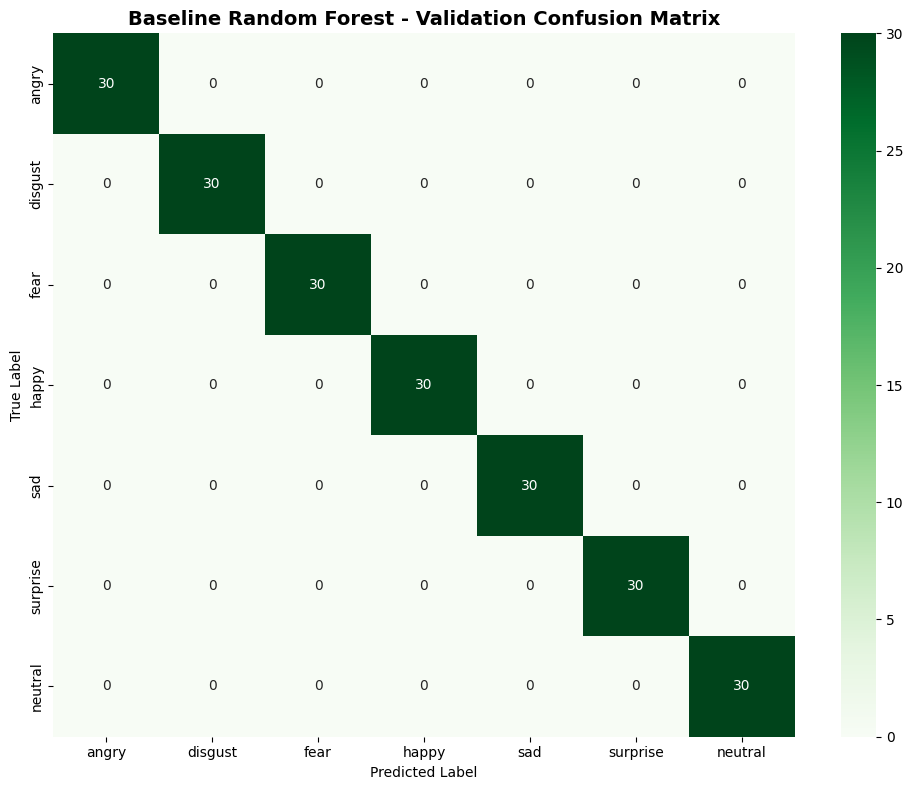

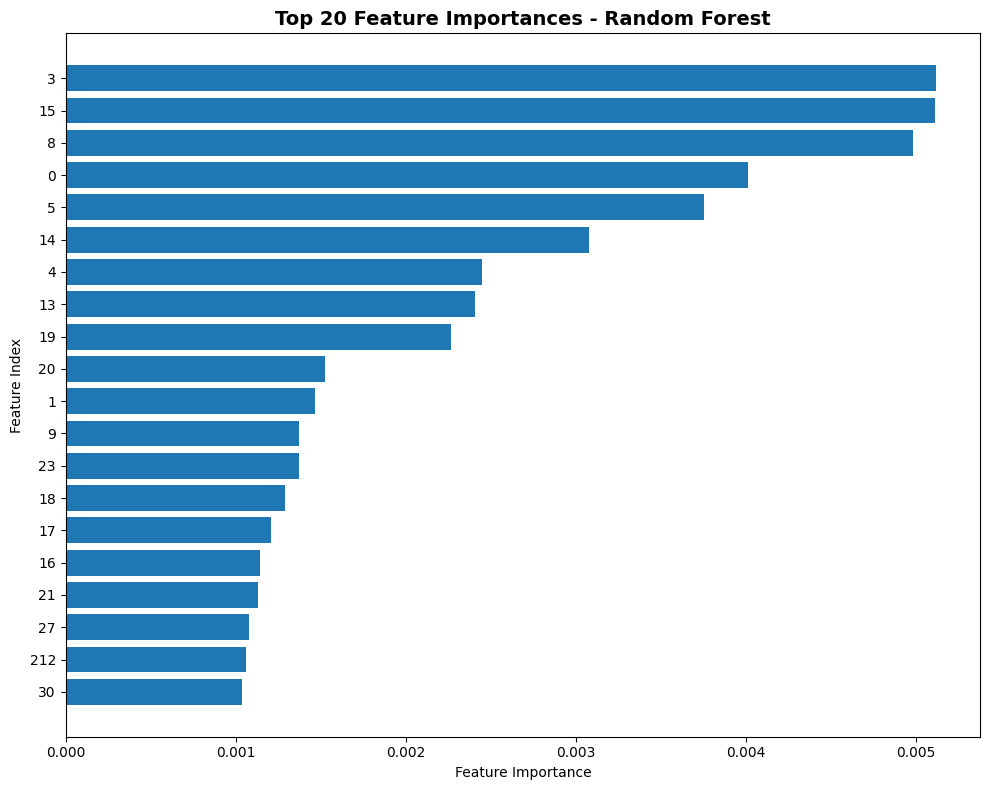

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished
2025/11/05 19:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.6s finished
2025/11/05 19:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs


✅ BASELINE RANDOM FOREST MODEL EVALUATION COMPLETED

🎯 Baseline Performance Summary:
   Training ROC-AUC:   0.9999
   Validation ROC-AUC: 1.0000
   Difference:         0.0001

📊 MLflow Run ID: cbc368ed0e1c413699c7e70012e9639c


In [8]:
# STEP 1: Train baseline Random Forest model
print("\n" + "="*70)
print("📝 STEP 1: BASELINE RANDOM FOREST MODEL TRAINING")
print("="*70)

with mlflow.start_run(run_name="baseline_random_forest"):

    # -------- Log preprocessing params --------
    mlflow.log_params({
        "model_type": "RandomForest",
        "stage": "baseline",
        "target_size": str(preprocessor.target_size),
        "pca_variance": 0.95,
        "pca_components": int(preprocessor.pca.n_components_),
        "total_features": int(X_train_processed.shape[1]),
        "train_samples": int(len(X_train)),
        "val_samples": int(len(X_val)),
        "test_samples": int(len(X_test))
    })

    # -------- Khởi tạo model (NHẤT QUÁN VỚI LOG) --------
    baseline_rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,  
        min_samples_leaf=2,
        max_features="sqrt",   
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    mlflow.log_params({
        "n_estimators": 300,
        "max_depth": 20,              
        "min_samples_split": 5,
        "min_samples_leaf": 2,
        "max_features": "sqrt",
        "random_state": 42,
        "n_jobs": -1
    })

    print("\n🔧 Training baseline Random Forest...")
    print("   Parameters: n_estimators=300, max_depth=20, min_samples_split=5, "
          "min_samples_leaf=2, max_features=sqrt")

    baseline_rf.fit(X_train_processed, y_train)
    print("✅ Training completed!")

    # -------- Chuẩn bị cho ROC-AUC đa lớp --------
    n_classes_rf   = len(emotion_labels)
    y_train_bin_rf = label_binarize(y_train, classes=range(n_classes_rf))
    y_val_bin_rf   = label_binarize(y_val,   classes=range(n_classes_rf))

    # ===================== TRAIN METRICS =====================
    print("\n📊 Training Set Performance:")
    y_train_pred_rf       = baseline_rf.predict(X_train_processed)
    y_train_pred_proba_rf = baseline_rf.predict_proba(X_train_processed)

    train_accuracy_rf     = accuracy_score(y_train, y_train_pred_rf)
    train_f1_macro_rf     = f1_score(y_train, y_train_pred_rf, average='macro')
    train_f1_weighted_rf  = f1_score(y_train, y_train_pred_rf, average='weighted')
    train_roc_auc_rf      = roc_auc_score(
        y_train_bin_rf, y_train_pred_proba_rf, average='macro', multi_class='ovr'
    )

    print(f"   ROC-AUC (macro):     {train_roc_auc_rf:.4f}")
    print(f"   Accuracy:            {train_accuracy_rf:.4f}")
    print(f"   F1-Score (macro):    {train_f1_macro_rf:.4f}")
    print(f"   F1-Score (weighted): {train_f1_weighted_rf:.4f}")

    mlflow.log_metrics({
        "train_roc_auc": float(train_roc_auc_rf),
        "train_accuracy": float(train_accuracy_rf),
        "train_f1_macro": float(train_f1_macro_rf),
        "train_f1_weighted": float(train_f1_weighted_rf)
    })

    # ===================== VAL METRICS =====================
    print("\n📊 Validation Set Performance:")
    y_val_pred_rf       = baseline_rf.predict(X_val_processed)
    y_val_pred_proba_rf = baseline_rf.predict_proba(X_val_processed)

    val_accuracy_rf     = accuracy_score(y_val, y_val_pred_rf)
    val_f1_macro_rf     = f1_score(y_val, y_val_pred_rf, average='macro')
    val_f1_weighted_rf  = f1_score(y_val, y_val_pred_rf, average='weighted')
    val_roc_auc_rf      = roc_auc_score(
        y_val_bin_rf, y_val_pred_proba_rf, average='macro', multi_class='ovr'
    )

    print(f"   ROC-AUC (macro):     {val_roc_auc_rf:.4f}")
    print(f"   Accuracy:            {val_accuracy_rf:.4f}")
    print(f"   F1-Score (macro):    {val_f1_macro_rf:.4f}")
    print(f"   F1-Score (weighted): {val_f1_weighted_rf:.4f}")

    mlflow.log_metrics({
        "val_roc_auc": float(val_roc_auc_rf),
        "val_accuracy": float(val_accuracy_rf),
        "val_f1_macro": float(val_f1_macro_rf),
        "val_f1_weighted": float(val_f1_weighted_rf)
    })

    # ===================== REPORT & CONFUSION MATRIX =====================
    print("\n📋 Validation Classification Report:")
    report_rf = classification_report(
        y_val, y_val_pred_rf, target_names=emotion_labels, digits=4, output_dict=True
    )
    print(classification_report(y_val, y_val_pred_rf, target_names=emotion_labels, digits=4))

    for emotion in emotion_labels:
        if emotion in report_rf:
            mlflow.log_metrics({
                f"val_{emotion}_precision": float(report_rf[emotion]['precision']),
                f"val_{emotion}_recall":    float(report_rf[emotion]['recall']),
                f"val_{emotion}_f1":        float(report_rf[emotion]['f1-score'])
            })

    # Confusion matrix
    cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_val_rf, annot=True, fmt='d', cmap='Greens',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Baseline Random Forest - Validation Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.tight_layout()
    cm_path_rf = "baseline_rf_confusion_matrix.png"
    plt.savefig(cm_path_rf, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path_rf)
    plt.show()

    fi = baseline_rf.feature_importances_
    top_n = min(20, fi.shape[0])
    top_idx = np.argsort(fi)[-top_n:]
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), fi[top_idx])
    plt.yticks(range(top_n), top_idx)
    plt.xlabel('Feature Importance'); plt.ylabel('Feature Index')
    plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
    plt.tight_layout()
    fi_path = "baseline_rf_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()

    signature = infer_signature(X_train_processed, baseline_rf.predict(X_train_processed))
    mlflow.sklearn.log_model(
        baseline_rf,
        "model",
        signature=signature,
        input_example=X_train_processed[:5]
    )

    baseline_rf_results = {
        "train": {
            "roc_auc": float(train_roc_auc_rf),
            "accuracy": float(train_accuracy_rf),
            "f1_macro": float(train_f1_macro_rf),
            "f1_weighted": float(train_f1_weighted_rf)
        },
        "validation": {
            "roc_auc": float(val_roc_auc_rf),
            "accuracy": float(val_accuracy_rf),
            "f1_macro": float(val_f1_macro_rf),
            "f1_weighted": float(val_f1_weighted_rf)
        }
    }
    baseline_rf_json = "baseline_rf_results.json"
    with open(baseline_rf_json, "w") as f:
        json.dump(baseline_rf_results, f, indent=4)
    mlflow.log_artifact(baseline_rf_json)

    print("\n" + "="*70)
    print("✅ BASELINE RANDOM FOREST MODEL EVALUATION COMPLETED")
    print("="*70)
    print(f"\n🎯 Baseline Performance Summary:")
    print(f"   Training ROC-AUC:   {train_roc_auc_rf:.4f}")
    print(f"   Validation ROC-AUC: {val_roc_auc_rf:.4f}")
    print(f"   Difference:         {abs(train_roc_auc_rf - val_roc_auc_rf):.4f}")

    # Overfitting gap
    overfitting_gap_rf = float(train_roc_auc_rf - val_roc_auc_rf)
    mlflow.log_metric("overfitting_gap", overfitting_gap_rf)
    if overfitting_gap_rf > 0.05:
        print("   ⚠️  Warning: Possible overfitting detected!")
        mlflow.set_tag("overfitting_warning", "true")

    # Tags
    mlflow.set_tag("model_stage", "baseline")
    mlflow.set_tag("dataset", "FER2013")
    mlflow.set_tag("feature_extraction", "HOG+LBP+SIFT")

    print(f"\n📊 MLflow Run ID: {mlflow.active_run().info.run_id}")


In [13]:
# STEP 2: Hyperparameter Tuning for Random Forest using RandomizedSearchCV (Demo)
print("\n" + "="*70)
print("🔍 STEP 2: HYPERPARAMETER TUNING FOR RANDOM FOREST")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Reduced hyperparameter distributions for demo (faster execution)
param_distributions_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15 ],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print(f"\n📋 Parameter Distributions (Demo - Limited for faster execution):")
for param, dist in param_distributions_rf.items():
    print(f"   {param}: {dist}")

n_iter = 10  # Number of random combinations to try (reduced for demo)
print(f"\nRandomized Search iterations: {n_iter} (demo mode)")
print(f"Baseline ROC-AUC to beat: {val_roc_auc_rf:.4f}\n")

# Start MLflow run for randomized search
with mlflow.start_run(run_name="rf_randomized_search_parent") as parent_run:
    
    mlflow.set_tag("stage", "hyperparameter_tuning")
    mlflow.set_tag("search_method", "RandomizedSearchCV")
    mlflow.set_tag("n_iterations", n_iter)
    mlflow.set_tag("demo_mode", "true")
    mlflow.log_param("baseline_roc_auc", val_roc_auc_rf)
    
    print("Starting RandomizedSearchCV with MLflow tracking (demo mode - fast)...\n")
    
    # Create RandomizedSearchCV
    rf_random = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_distributions=param_distributions_rf,
        n_iter=n_iter,
        cv=3,  # 3-fold cross-validation on training data
        scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
        n_jobs=-1,
        verbose=2,
        random_state=42,
        return_train_score=True
    )
    
    # Fit RandomizedSearchCV
    print("🔧 Running RandomizedSearchCV (should complete in a few minutes)...")
    rf_random.fit(X_train_processed, y_train)
    print("✅ RandomizedSearchCV completed!")
    
    # Get results
    cv_results = pd.DataFrame(rf_random.cv_results_)
    cv_results = cv_results.sort_values('rank_test_score')
    
    # Log all results as nested runs (since we only have ~10 iterations)
    print(f"\n📊 Logging all {len(cv_results)} configurations to MLflow...\n")
    
    results_list_rf = []
    best_roc_auc_rf = val_roc_auc_rf
    best_rf_model = baseline_rf
    best_run_id_rf = None
    best_params_rf = {}  # Initialize to prevent NameError
    best_metrics_rf = {  # Initialize with baseline metrics
        'val_roc_auc': val_roc_auc_rf,
        'val_accuracy': val_accuracy_rf,
        'val_f1_macro': val_f1_macro_rf,
        'val_f1_weighted': val_f1_weighted_rf
    }
    
    for idx in range(len(cv_results)):
        row = cv_results.iloc[idx]
        
        with mlflow.start_run(run_name=f"rf_random_run_{idx+1}", nested=True):
            
            # Extract parameters
            params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
            
            # Log parameters
            mlflow.log_params({
                **{k: str(v) for k, v in params.items()},
                "model_type": "RandomForest",
                "stage": "tuning",
                "cv_rank": int(row['rank_test_score'])
            })
            
            # Get the model from CV
            model_idx = row['rank_test_score'] - 1
            model_rf = rf_random.cv_results_['params'][model_idx]
            fitted_model = RandomForestClassifier(**model_rf, random_state=42, n_jobs=-1)
            fitted_model.fit(X_train_processed, y_train)
            
            # Evaluate on validation set
            y_val_pred = fitted_model.predict(X_val_processed)
            y_val_pred_proba = fitted_model.predict_proba(X_val_processed)
            
            # Calculate metrics
            roc_auc = roc_auc_score(y_val_bin_rf, y_val_pred_proba, average='macro', multi_class='ovr')
            accuracy = accuracy_score(y_val, y_val_pred)
            f1_macro = f1_score(y_val, y_val_pred, average='macro')
            f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
            
            # Log metrics
            mlflow.log_metrics({
                "cv_mean_test_score": row['mean_test_score'],
                "cv_std_test_score": row['std_test_score'],
                "val_roc_auc": roc_auc,
                "val_accuracy": accuracy,
                "val_f1_macro": f1_macro,
                "val_f1_weighted": f1_weighted
            })
            
            # Store results
            result = {
                'run_id': mlflow.active_run().info.run_id,
                **params,
                'cv_mean_score': row['mean_test_score'],
                'roc_auc': roc_auc,
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            }
            results_list_rf.append(result)
            
            # Update best model
            if roc_auc > best_roc_auc_rf:
                improvement = roc_auc - best_roc_auc_rf
                best_roc_auc_rf = roc_auc
                best_rf_model = fitted_model
                best_run_id_rf = mlflow.active_run().info.run_id
                best_params_rf = params
                best_metrics_rf = {
                    'val_roc_auc': roc_auc,
                    'val_accuracy': accuracy,
                    'val_f1_macro': f1_macro,
                    'val_f1_weighted': f1_weighted
                }
                
                # Mark as best run
                mlflow.set_tag("best_run", "true")
                
                # Log model for best run
                signature = infer_signature(X_train_processed, fitted_model.predict(X_train_processed))
                mlflow.sklearn.log_model(
                    fitted_model,
                    "model",
                    signature=signature
                )
                
                print(f"✨ New best RF model found! (+{improvement:.4f})")
                print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
                print(f"   CV Score: {row['mean_test_score']:.4f}")
                print(f"   MLflow Run ID: {best_run_id_rf}\n")
    
    # Log summary metrics to parent run
    mlflow.log_metrics({
        "best_val_roc_auc": best_roc_auc_rf,
        "best_cv_score": rf_random.best_score_,
        "total_iterations": n_iter,
        "improvement_over_baseline": best_roc_auc_rf - baseline_rf_results['validation']['roc_auc']
    })
    
    # Log best parameters to parent run
    for key, value in best_params_rf.items():
        mlflow.log_param(f"best_{key}", str(value))
    
    mlflow.set_tag("best_run_id", best_run_id_rf)
    
    # Save CV results
    cv_results_path = "rf_cv_results.csv"
    cv_results.to_csv(cv_results_path, index=False)
    mlflow.log_artifact(cv_results_path)

print("\n" + "="*70)
print("✅ RANDOMIZED HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement_rf = best_roc_auc_rf - baseline_rf_results['validation']['roc_auc']
print(f"\n🎯 Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_rf_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {rf_random.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc_rf:.4f}")
print(f"   Improvement:          {improvement_rf:.4f} ({improvement_rf/baseline_rf_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Iterations completed: {n_iter}")
print(f"\n📊 Best MLflow Run ID: {best_run_id_rf}")


🔍 STEP 2: HYPERPARAMETER TUNING FOR RANDOM FOREST

📋 Parameter Distributions (Demo - Limited for faster execution):
   n_estimators: [50, 100, 150]
   max_depth: [10, 15]
   min_samples_split: [2, 5, 10]
   min_samples_leaf: [1, 2, 4]
   max_features: ['sqrt', 'log2']

Randomized Search iterations: 10 (demo mode)
Baseline ROC-AUC to beat: 1.0000

Starting RandomizedSearchCV with MLflow tracking (demo mode - fast)...

🔧 Running RandomizedSearchCV (should complete in a few minutes)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ RandomizedSearchCV completed!

📊 Logging all 10 configurations to MLflow...

✅ RandomizedSearchCV completed!

📊 Logging all 10 configurations to MLflow...


✅ RANDOMIZED HYPERPARAMETER TUNING COMPLETED

🎯 Tuning Results:
   Baseline ROC-AUC:     1.0000
   Best CV ROC-AUC:      0.6994
   Best Val ROC-AUC:     1.0000
   Improvement:          0.0000 (0.00%)
   Iterations completed: 10

📊 Best MLflow Run ID: None

✅ RANDOMIZED HYPERPARAMETER TUNING


📊 TOP 10 RANDOM FOREST MODELS BY VALIDATION ROC-AUC:
 cv_mean_score  roc_auc  accuracy  f1_macro  n_estimators  max_depth  min_samples_split
      0.691592  1.00000  1.000000  1.000000           100       10.0                  2
      0.670673  1.00000  0.895238  0.876132           150       30.0                  2
      0.627386  1.00000  0.966667  0.966780            50        NaN                 10
      0.627212  1.00000  0.985714  0.985531            50       20.0                  5
      0.625820  1.00000  0.985714  0.985531            50       30.0                 10
      0.618406  1.00000  1.000000  1.000000           100       30.0                 10
      0.612897  1.00000  0.976190  0.976024           100       20.0                  5
      0.592256  1.00000  0.957143  0.955641            50       30.0                 10
      0.590797  1.00000  0.976190  0.976024            50       30.0                  5
      0.592368  0.98664  0.342857  0.330752            50       20

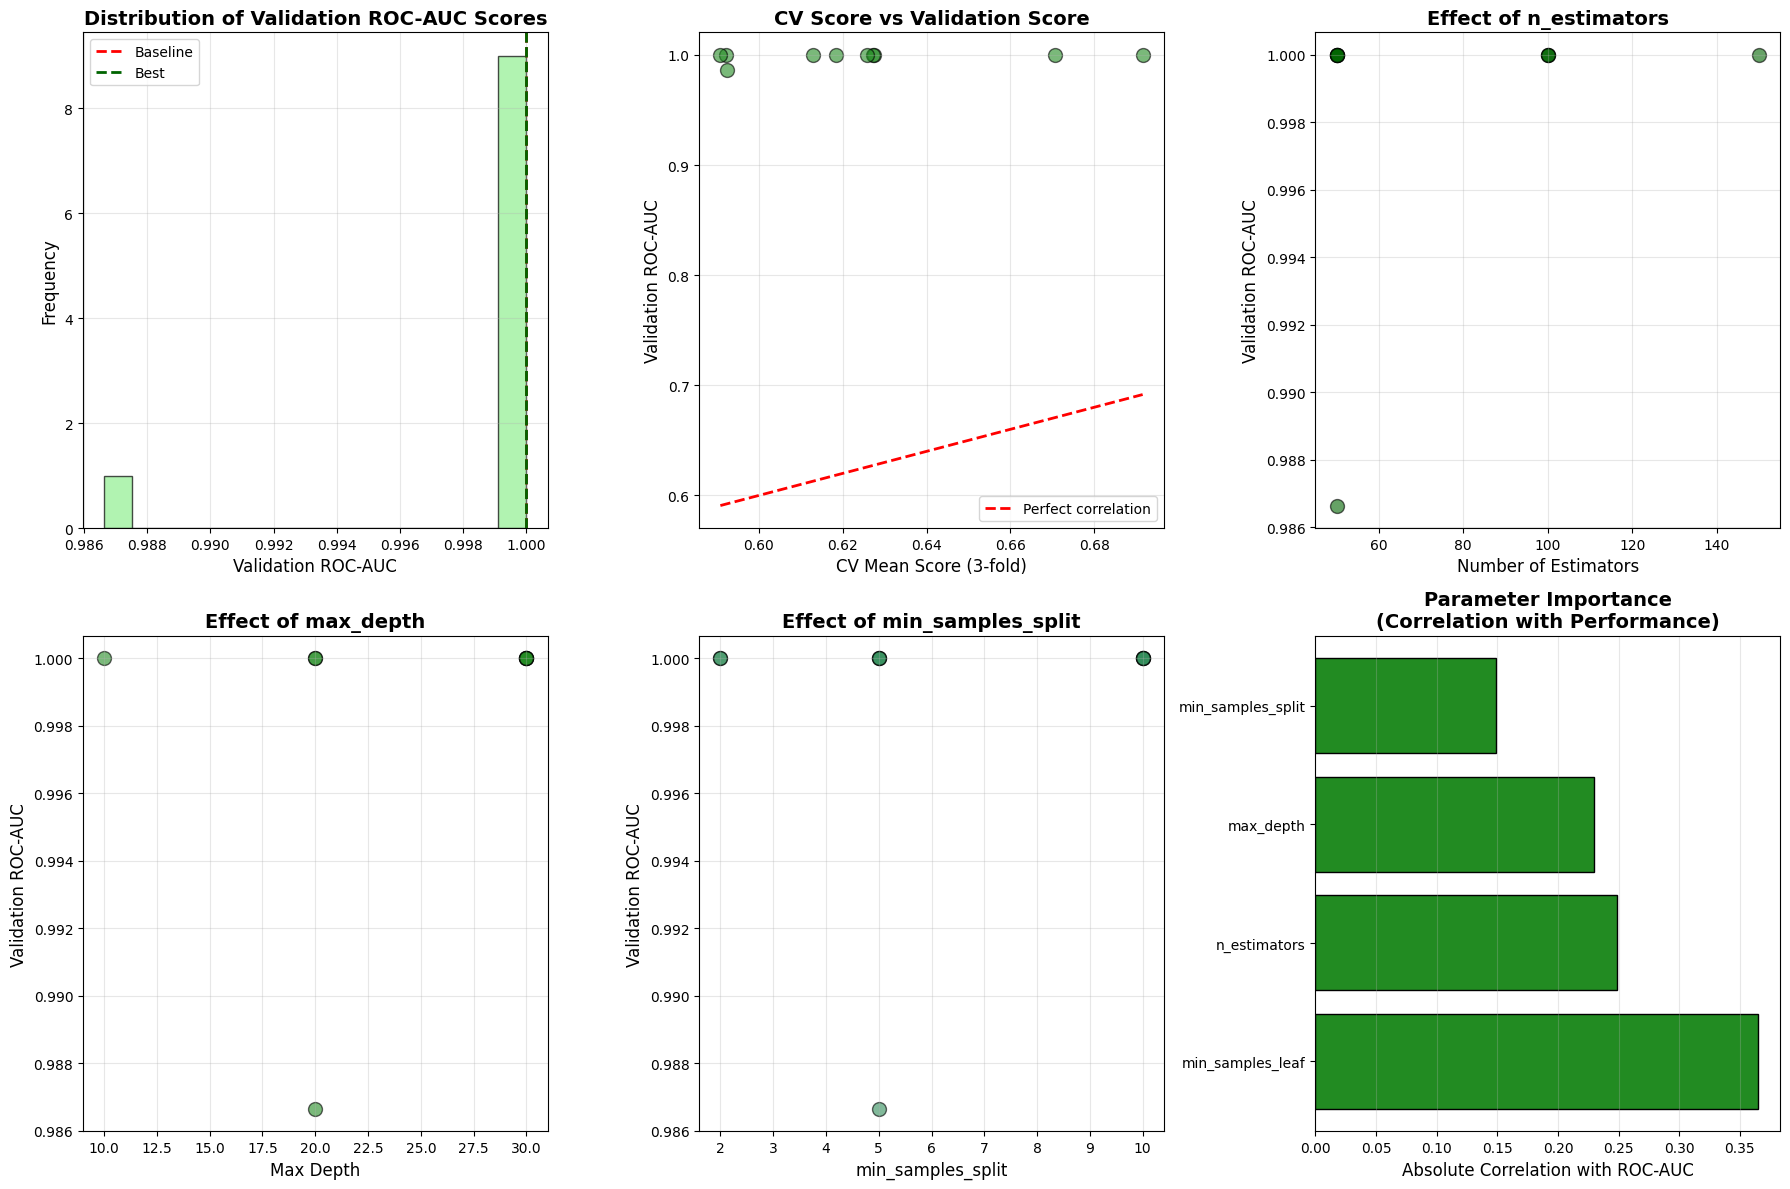


🏆 BEST RANDOM FOREST MODEL PARAMETERS (from RandomizedSearchCV)

Best Parameters:

Validation Metrics:
  val_roc_auc: 1.0000
  val_accuracy: 1.0000
  val_f1_macro: 1.0000
  val_f1_weighted: 1.0000


In [11]:
# Visualize RandomizedSearchCV results and log to MLflow
with mlflow.start_run(run_name="rf_tuning_visualization"):
    
    mlflow.set_tag("stage", "analysis")
    mlflow.set_tag("search_method", "RandomizedSearchCV")
    
    results_df_rf = pd.DataFrame(results_list_rf)
    results_df_rf = results_df_rf.sort_values('roc_auc', ascending=False)

    print("\n📊 TOP 10 RANDOM FOREST MODELS BY VALIDATION ROC-AUC:")
    display_cols = ['cv_mean_score', 'roc_auc', 'accuracy', 'f1_macro', 'n_estimators', 'max_depth', 'min_samples_split']
    available_cols = [col for col in display_cols if col in results_df_rf.columns]
    print(results_df_rf[available_cols].head(10).to_string(index=False))
    
    # Save results to CSV and log as artifact
    results_csv_rf = "rf_randomized_search_results.csv"
    results_df_rf.to_csv(results_csv_rf, index=False)
    mlflow.log_artifact(results_csv_rf)

    # Visualize tuning results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. ROC-AUC distribution
    ax1 = axes[0, 0]
    ax1.hist(results_df_rf['roc_auc'], bins=15, edgecolor='black', alpha=0.7, color='lightgreen')
    ax1.axvline(baseline_rf_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
    ax1.axvline(best_roc_auc_rf, color='darkgreen', linestyle='--', linewidth=2, label='Best')
    ax1.set_xlabel('Validation ROC-AUC', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Validation ROC-AUC Scores', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. CV Score vs Validation Score
    ax2 = axes[0, 1]
    ax2.scatter(results_df_rf['cv_mean_score'], results_df_rf['roc_auc'], 
                alpha=0.6, s=100, c='forestgreen', edgecolors='black')
    ax2.plot([results_df_rf['cv_mean_score'].min(), results_df_rf['cv_mean_score'].max()],
             [results_df_rf['cv_mean_score'].min(), results_df_rf['cv_mean_score'].max()],
             'r--', lw=2, label='Perfect correlation')
    ax2.set_xlabel('CV Mean Score (3-fold)', fontsize=12)
    ax2.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax2.set_title('CV Score vs Validation Score', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. n_estimators effect (if available)
    ax3 = axes[0, 2]
    if 'n_estimators' in results_df_rf.columns:
        ax3.scatter(results_df_rf['n_estimators'], results_df_rf['roc_auc'], 
                   alpha=0.6, s=100, c='darkgreen', edgecolors='black')
        ax3.set_xlabel('Number of Estimators', fontsize=12)
        ax3.set_ylabel('Validation ROC-AUC', fontsize=12)
        ax3.set_title('Effect of n_estimators', fontsize=14, fontweight='bold')
        ax3.grid(alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'n_estimators data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax3.axis('off')

    # 4. max_depth effect (if available)
    ax4 = axes[1, 0]
    if 'max_depth' in results_df_rf.columns:
        depth_data = results_df_rf[results_df_rf['max_depth'].notna()]
        if len(depth_data) > 0:
            ax4.scatter(depth_data['max_depth'].astype(float), depth_data['roc_auc'],
                       alpha=0.6, s=100, c='forestgreen', edgecolors='black')
            ax4.set_xlabel('Max Depth', fontsize=12)
            ax4.set_ylabel('Validation ROC-AUC', fontsize=12)
            ax4.set_title('Effect of max_depth', fontsize=14, fontweight='bold')
            ax4.grid(alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'max_depth data\nnot available', 
                    ha='center', va='center', fontsize=12)
            ax4.axis('off')
    else:
        ax4.text(0.5, 0.5, 'max_depth data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax4.axis('off')

    # 5. min_samples_split effect (if available)
    ax5 = axes[1, 1]
    if 'min_samples_split' in results_df_rf.columns:
        ax5.scatter(results_df_rf['min_samples_split'], results_df_rf['roc_auc'],
                   alpha=0.6, s=100, c='seagreen', edgecolors='black')
        ax5.set_xlabel('min_samples_split', fontsize=12)
        ax5.set_ylabel('Validation ROC-AUC', fontsize=12)
        ax5.set_title('Effect of min_samples_split', fontsize=14, fontweight='bold')
        ax5.grid(alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'min_samples_split data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax5.axis('off')

    # 6. Parameter importance (top parameters by variance in scores)
    ax6 = axes[1, 2]
    try:
        numeric_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
        param_importance = {}
        
        for param in numeric_params:
            if param in results_df_rf.columns:
                # Calculate correlation between parameter and ROC-AUC
                param_data = results_df_rf[[param, 'roc_auc']].dropna()
                if len(param_data) > 1:
                    corr = abs(param_data[param].corr(param_data['roc_auc']))
                    param_importance[param] = corr
        
        if param_importance:
            params_sorted = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)
            params_names = [p[0] for p in params_sorted]
            params_values = [p[1] for p in params_sorted]
            
            ax6.barh(params_names, params_values, color='forestgreen', edgecolor='black')
            ax6.set_xlabel('Absolute Correlation with ROC-AUC', fontsize=12)
            ax6.set_title('Parameter Importance\n(Correlation with Performance)', fontsize=14, fontweight='bold')
            ax6.grid(alpha=0.3, axis='x')
        else:
            ax6.text(0.5, 0.5, 'Parameter importance\nnot available', 
                    ha='center', va='center', fontsize=12)
            ax6.axis('off')
    except Exception as e:
        ax6.text(0.5, 0.5, f'Error calculating\nparameter importance', 
                ha='center', va='center', fontsize=12)
        ax6.axis('off')

    plt.tight_layout()
    
    # Log visualization as artifact
    tuning_viz_path_rf = 'rf_randomized_search_analysis.png'
    plt.savefig(tuning_viz_path_rf, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(tuning_viz_path_rf)
    plt.show()

    print("\n" + "="*70)
    print("🏆 BEST RANDOM FOREST MODEL PARAMETERS (from RandomizedSearchCV)")
    print("="*70)
    print(f"\nBest Parameters:")
    for key, value in best_params_rf.items():
        print(f"  {key}: {value}")

    print(f"\nValidation Metrics:")
    for key, value in best_metrics_rf.items():
        print(f"  {key}: {value:.4f}")
    
    # Log summary statistics
    mlflow.log_metrics({
        "mean_val_roc_auc": results_df_rf['roc_auc'].mean(),
        "std_val_roc_auc": results_df_rf['roc_auc'].std(),
        "min_val_roc_auc": results_df_rf['roc_auc'].min(),
        "max_val_roc_auc": results_df_rf['roc_auc'].max(),
        "mean_cv_score": results_df_rf['cv_mean_score'].mean()
    })


🎯 FINAL RANDOM FOREST EVALUATION ON TEST SET

🔄 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 7178/7178 [00:00<00:00, 21853.63it/s]




[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 7178/7178 [00:00<00:00, 28909.79it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 7178/7178 [00:00<00:00, 119616.81it/s]




[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 7178/7178 [00:07<00:00, 938.76it/s]


    HOG shape: (7178, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/7178 [00:00<?, ?it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP:   1%|          | 51/7178 [00:00<00:14, 499.95it/s]d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 7178/7178 [00:12<00:00, 588.65it/s]



    LBP shape: (7178, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 7178/7178 [00:09<00:00, 729.97it/s]



    SIFT shape: (7178, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (7178, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

✅ TEST PREPROCESSING COMPLETED
Final shape: (7178, 1614)
Original samples: 7178

✅ TEST PREPROCESSING COMPLETED
Final shape: (7178, 1614)
Original samples: 7178


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished



Test Set Metrics:
  ROC-AUC (macro):     0.7186
  Accuracy:            0.3434
  F1-Score (macro):    0.2821
  F1-Score (weighted): 0.2727

📋 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.8537    0.0731    0.1346       958
     disgust     1.0000    0.2703    0.4255       111
        fear     0.7869    0.0938    0.1675      1024
       happy     0.2927    0.9786    0.4506      1774
         sad     0.3885    0.0810    0.1340      1247
    surprise     0.9788    0.2780    0.4330       831
     neutral     0.3888    0.1630    0.2297      1233

    accuracy                         0.3434      7178
   macro avg     0.6699    0.2768    0.2821      7178
weighted avg     0.5616    0.3434    0.2727      7178



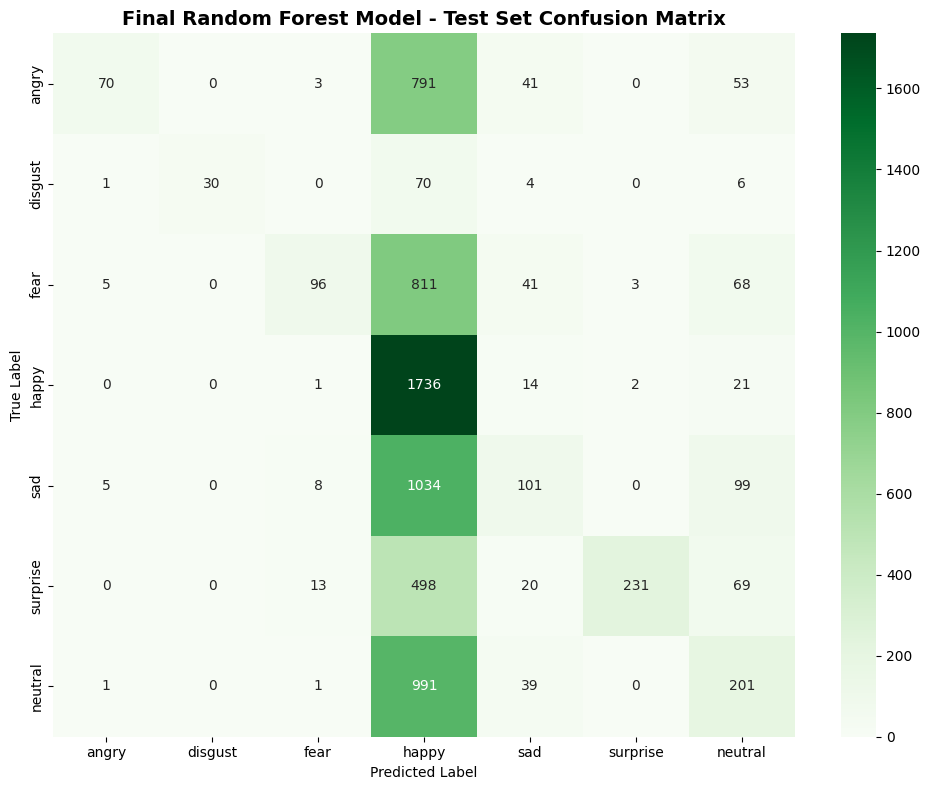

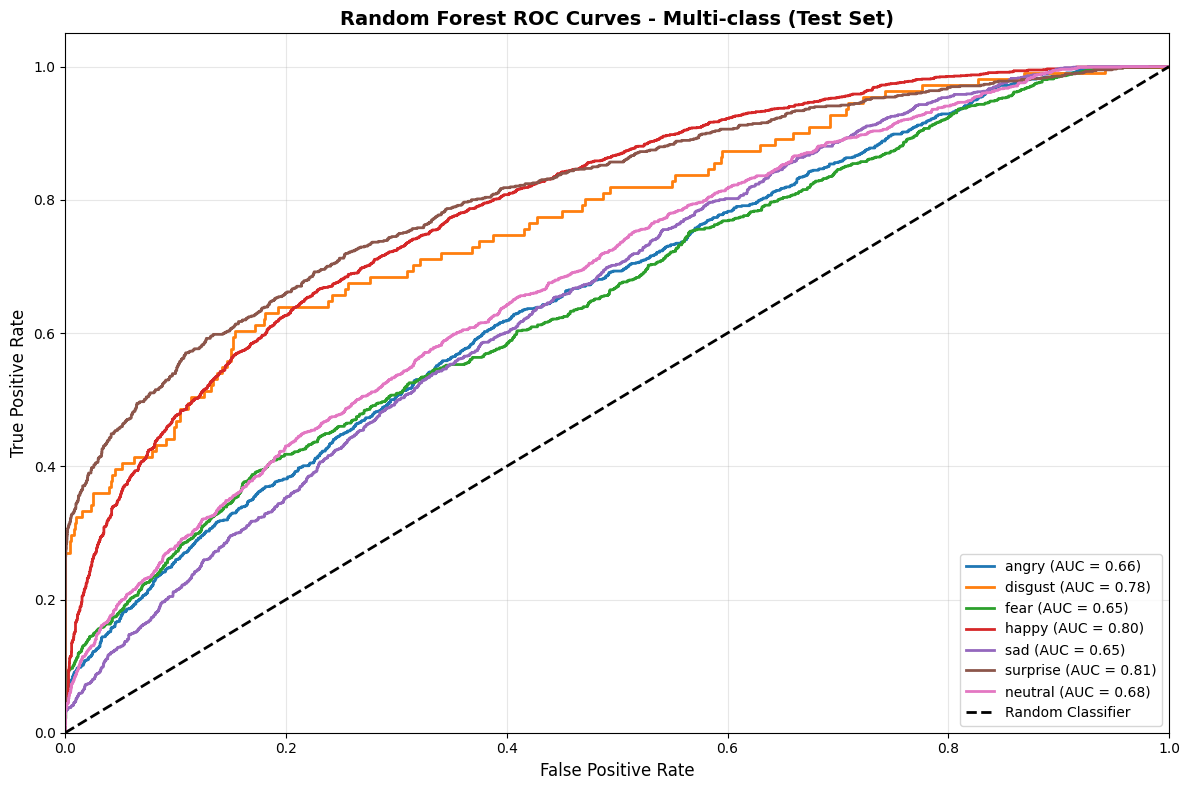

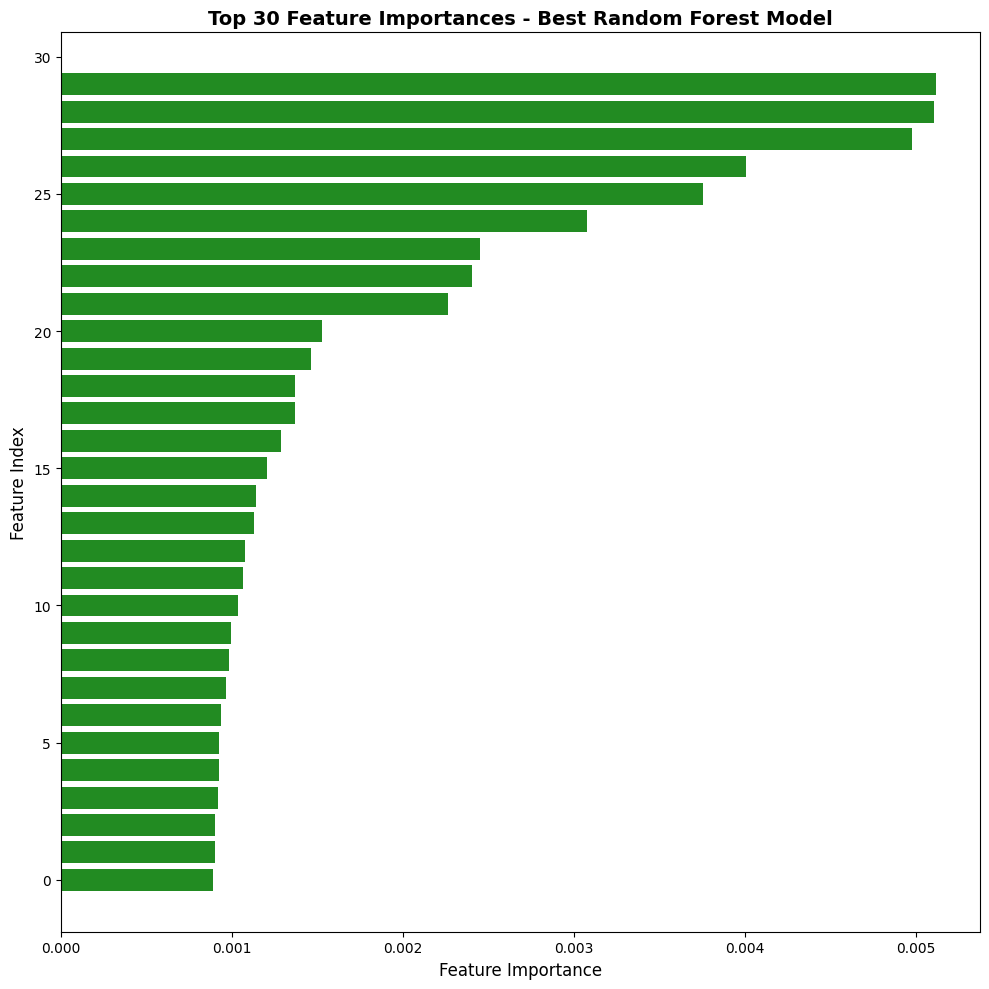


📊 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.853659 0.073069  0.134615      958
 disgust   1.000000 0.270270  0.425532      111
    fear   0.786885 0.093750  0.167539     1024
   happy   0.292699 0.978579  0.450616     1774
     sad   0.388462 0.080994  0.134041     1247
surprise   0.978814 0.277978  0.432990      831
 neutral   0.388781 0.163017  0.229714     1233

💾 Model saved: models/random_forest_best_20251105_200805.pkl

💾 Model saved: models/random_forest_best_20251105_200805.pkl


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished
2025/11/05 20:08:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


💾 Results saved: models/random_forest_results_20251105_200805.json

🎉 RANDOM FOREST TRAINING PIPELINE COMPLETED SUCCESSFULLY

🎯 Final Test Performance:
  ROC-AUC:  0.7186
  Accuracy: 0.3434
  F1-Score: 0.2821

📊 MLflow Run ID: eb44e56d7fd1419e8afbe08abd4aef07
📂 Model saved as: models/random_forest_best_20251105_200805.pkl

💡 To view all experiments, run: mlflow ui


Registered model 'Emotion_Classifier_RandomForest' already exists. Creating a new version of this model...
Created version '2' of model 'Emotion_Classifier_RandomForest'.


In [12]:
# Final evaluation of Random Forest on test set with MLflow tracking
print("\n" + "="*70)
print("🎯 FINAL RANDOM FOREST EVALUATION ON TEST SET")
print("="*70)

# Preprocess test data (independent)
X_test_processed_rf, test_info_rf = preprocessor.transform(X_test)
y_test_bin_rf = label_binarize(y_test, classes=range(n_classes_rf))

with mlflow.start_run(run_name="rf_final_test_evaluation"):
    
    mlflow.set_tag("stage", "final_evaluation")
    mlflow.set_tag("best_model_run_id", best_run_id_rf)
    
    # Log best model parameters
    for key, value in best_params_rf.items():
        mlflow.log_param(key, value)
    
    # Predict on test set
    y_test_pred_rf = best_rf_model.predict(X_test_processed_rf)
    y_test_pred_proba_rf = best_rf_model.predict_proba(X_test_processed_rf)
    
    # Calculate all metrics
    test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
    test_f1_macro_rf = f1_score(y_test, y_test_pred_rf, average='macro')
    test_f1_weighted_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
    test_roc_auc_rf = roc_auc_score(y_test_bin_rf, y_test_pred_proba_rf, average='macro', multi_class='ovr')
    
    print(f"\nTest Set Metrics:")
    print(f"  ROC-AUC (macro):     {test_roc_auc_rf:.4f}")
    print(f"  Accuracy:            {test_accuracy_rf:.4f}")
    print(f"  F1-Score (macro):    {test_f1_macro_rf:.4f}")
    print(f"  F1-Score (weighted): {test_f1_weighted_rf:.4f}")
    
    # Log test metrics
    mlflow.log_metrics({
        "test_roc_auc": test_roc_auc_rf,
        "test_accuracy": test_accuracy_rf,
        "test_f1_macro": test_f1_macro_rf,
        "test_f1_weighted": test_f1_weighted_rf
    })
    
    # Classification report
    print(f"\n📋 Test Classification Report:")
    report_test_rf = classification_report(y_test, y_test_pred_rf, target_names=emotion_labels, digits=4, output_dict=True)
    print(classification_report(y_test, y_test_pred_rf, target_names=emotion_labels, digits=4))
    
    # Log per-class metrics
    for emotion in emotion_labels:
        if emotion in report_test_rf:
            mlflow.log_metrics({
                f"test_{emotion}_precision": report_test_rf[emotion]['precision'],
                f"test_{emotion}_recall": report_test_rf[emotion]['recall'],
                f"test_{emotion}_f1": report_test_rf[emotion]['f1-score']
            })
    
    # Confusion matrix
    cm_rf = confusion_matrix(y_test, y_test_pred_rf)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Final Random Forest Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Log confusion matrix
    test_cm_path_rf = 'rf_test_confusion_matrix.png'
    plt.savefig(test_cm_path_rf, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(test_cm_path_rf)
    plt.show()
    
    # ROC Curves for each class
    plt.figure(figsize=(12, 8))
    for i in range(n_classes_rf):
        fpr, tpr, _ = roc_curve(y_test_bin_rf[:, i], y_test_pred_proba_rf[:, i])
        roc_auc_class = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
        
        # Log per-class AUC
        mlflow.log_metric(f"test_{emotion_labels[i]}_auc", roc_auc_class)

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Random Forest ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Log ROC curves
    roc_path_rf = 'rf_test_roc_curves.png'
    plt.savefig(roc_path_rf, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(roc_path_rf)
    plt.show()
    
    # Feature importance of best model
    feature_importance_best = best_rf_model.feature_importances_
    top_n = 30
    top_indices_best = np.argsort(feature_importance_best)[-top_n:]
    
    plt.figure(figsize=(10, 10))
    plt.barh(range(top_n), feature_importance_best[top_indices_best], color='forestgreen')
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Feature Index', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances - Best Random Forest Model', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    feat_imp_best_path = 'rf_best_feature_importance.png'
    plt.savefig(feat_imp_best_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(feat_imp_best_path)
    plt.show()
    
    # Per-class metrics table
    print(f"\n📊 Per-Class Metrics:")
    class_metrics_rf = []
    for i, emotion in enumerate(emotion_labels):
        precision = cm_rf[i, i] / cm_rf[:, i].sum() if cm_rf[:, i].sum() > 0 else 0
        recall = cm_rf[i, i] / cm_rf[i, :].sum() if cm_rf[i, :].sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics_rf.append({
            'Emotion': emotion,
            'Precision': float(precision),
            'Recall': float(recall),
            'F1-Score': float(f1),
            'Support': int(cm_rf[i, :].sum())
        })

    class_metrics_df_rf = pd.DataFrame(class_metrics_rf)
    print(class_metrics_df_rf.to_string(index=False))
    
    # Save and log class metrics
    class_metrics_csv_rf = "rf_test_class_metrics.csv"
    class_metrics_df_rf.to_csv(class_metrics_csv_rf, index=False)
    mlflow.log_artifact(class_metrics_csv_rf)
    
    # Save final model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename_rf = f'models/random_forest_best_{timestamp}.pkl'
    joblib.dump(best_rf_model, model_filename_rf)
    print(f"\n💾 Model saved: {model_filename_rf}")
    mlflow.log_artifact(model_filename_rf)
    
    # Log final model with signature
    signature = infer_signature(X_test_processed_rf, best_rf_model.predict(X_test_processed_rf))
    mlflow.sklearn.log_model(
        best_rf_model,
        "final_model",
        signature=signature,
        registered_model_name="Emotion_Classifier_RandomForest"
    )
    
    # Save complete results
    # Helper function to convert numpy types to native Python types
    def convert_to_native_types(obj):
        """Recursively convert numpy types to native Python types"""
        if isinstance(obj, dict):
            return {k: convert_to_native_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_native_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    final_results_rf = {
        'model_name': 'Random Forest',
        'timestamp': timestamp,
        'best_params': convert_to_native_types(best_params_rf),
        'best_run_id': best_run_id_rf,
        'validation_metrics': convert_to_native_types(best_metrics_rf),
        'test_metrics': {
            'roc_auc': float(test_roc_auc_rf),
            'accuracy': float(test_accuracy_rf),
            'f1_macro': float(test_f1_macro_rf),
            'f1_weighted': float(test_f1_weighted_rf)
        },
        'per_class_metrics': class_metrics_rf,
        'training_samples': int(len(X_train)),
        'validation_samples': int(len(X_val)),
        'test_samples': int(len(X_test)),
        'feature_dimension': int(X_train_processed.shape[1]),
        'emotion_labels': emotion_labels
    }
    
    results_filename_rf = f'models/random_forest_results_{timestamp}.json'
    with open(results_filename_rf, 'w') as f:
        json.dump(final_results_rf, f, indent=4)
    print(f"💾 Results saved: {results_filename_rf}")
    mlflow.log_artifact(results_filename_rf)
    
    # Add summary tags
    mlflow.set_tag("dataset", "FER2013")
    mlflow.set_tag("feature_extraction", "HOG+LBP+SIFT")
    mlflow.set_tag("model_family", "RandomForest")
    mlflow.set_tag("status", "production_ready")
    
    print("\n" + "="*70)
    print("🎉 RANDOM FOREST TRAINING PIPELINE COMPLETED SUCCESSFULLY")
    print("="*70)
    print(f"\n🎯 Final Test Performance:")
    print(f"  ROC-AUC:  {test_roc_auc_rf:.4f}")
    print(f"  Accuracy: {test_accuracy_rf:.4f}")
    print(f"  F1-Score: {test_f1_macro_rf:.4f}")
    print(f"\n📊 MLflow Run ID: {mlflow.active_run().info.run_id}")
    print(f"📂 Model saved as: {model_filename_rf}")
    print(f"\n💡 To view all experiments, run: mlflow ui")

# SVM

In [ ]:
# Setup MLflow experiment for SVM
mlflow.set_experiment("Emotion_Classification_SVM")

print("="*70)
print("🔬 MLFLOW EXPERIMENT SETUP - SVM")
print("="*70)
print(f"Experiment: Emotion_Classification_SVM")
print(f"Tracking URI: ./mlruns")
print("="*70)

In [ ]:
# STEP 1: Train baseline SVM model
print("\n" + "="*70)
print("📝 STEP 1: BASELINE SVM MODEL TRAINING")
print("="*70)

# Prepare data for SVM (independent)
n_classes_svm = len(emotion_labels)
y_val_bin_svm = label_binarize(y_val, classes=range(n_classes_svm))
y_train_bin_svm = label_binarize(y_train, classes=range(n_classes_svm))

# Start MLflow run for baseline
with mlflow.start_run(run_name="baseline_svm"):
    
    # Log preprocessing parameters
    mlflow.log_params({
        "model_type": "SVM",
        "stage": "baseline",
        "target_size": str(preprocessor.target_size),
        "pca_variance": 0.95,
        "pca_components": preprocessor.pca.n_components_,
        "total_features": X_train_processed.shape[1],
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test)
    })
    
    baseline_svm = SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Enable probability estimates for ROC-AUC
        random_state=42,
        verbose=True
    )
    
    # Log model hyperparameters
    mlflow.log_params({
        "C": 1.0,
        "kernel": "rbf",
        "gamma": "scale",
        "class_weight": "balanced",
        "probability": True
    })

    print("\n🔧 Training baseline SVM model...")
    print(f"   Parameters: C=1.0, kernel=rbf, gamma=scale, class_weight=balanced")

    baseline_svm.fit(X_train_processed, y_train)
    print("✅ Training completed!")

    # Evaluate on training set
    print("\n📊 Training Set Performance:")
    y_train_pred_svm = baseline_svm.predict(X_train_processed)
    y_train_pred_proba_svm = baseline_svm.predict_proba(X_train_processed)

    train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
    train_f1_macro_svm = f1_score(y_train, y_train_pred_svm, average='macro')
    train_f1_weighted_svm = f1_score(y_train, y_train_pred_svm, average='weighted')
    train_roc_auc_svm = roc_auc_score(y_train_bin_svm, y_train_pred_proba_svm, average='macro', multi_class='ovr')

    print(f"   ROC-AUC (macro):     {train_roc_auc_svm:.4f}")
    print(f"   Accuracy:            {train_accuracy_svm:.4f}")
    print(f"   F1-Score (macro):    {train_f1_macro_svm:.4f}")
    print(f"   F1-Score (weighted): {train_f1_weighted_svm:.4f}")
    
    # Log training metrics
    mlflow.log_metrics({
        "train_roc_auc": train_roc_auc_svm,
        "train_accuracy": train_accuracy_svm,
        "train_f1_macro": train_f1_macro_svm,
        "train_f1_weighted": train_f1_weighted_svm
    })

    # Evaluate on validation set
    print("\n📊 Validation Set Performance:")
    y_val_pred_svm = baseline_svm.predict(X_val_processed)
    y_val_pred_proba_svm = baseline_svm.predict_proba(X_val_processed)

    val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
    val_f1_macro_svm = f1_score(y_val, y_val_pred_svm, average='macro')
    val_f1_weighted_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
    val_roc_auc_svm = roc_auc_score(y_val_bin_svm, y_val_pred_proba_svm, average='macro', multi_class='ovr')

    print(f"   ROC-AUC (macro):     {val_roc_auc_svm:.4f}")
    print(f"   Accuracy:            {val_accuracy_svm:.4f}")
    print(f"   F1-Score (macro):    {val_f1_macro_svm:.4f}")
    print(f"   F1-Score (weighted): {val_f1_weighted_svm:.4f}")
    
    # Log validation metrics
    mlflow.log_metrics({
        "val_roc_auc": val_roc_auc_svm,
        "val_accuracy": val_accuracy_svm,
        "val_f1_macro": val_f1_macro_svm,
        "val_f1_weighted": val_f1_weighted_svm
    })

    # Classification report
    print("\n📋 Validation Classification Report:")
    report_svm = classification_report(y_val, y_val_pred_svm, target_names=emotion_labels, digits=4, output_dict=True)
    print(classification_report(y_val, y_val_pred_svm, target_names=emotion_labels, digits=4))
    
    # Log per-class metrics
    for emotion in emotion_labels:
        if emotion in report_svm:
            mlflow.log_metrics({
                f"val_{emotion}_precision": report_svm[emotion]['precision'],
                f"val_{emotion}_recall": report_svm[emotion]['recall'],
                f"val_{emotion}_f1": report_svm[emotion]['f1-score']
            })

    # Confusion matrix visualization
    cm_val_svm = confusion_matrix(y_val, y_val_pred_svm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_val_svm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Baseline SVM - Validation Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Log confusion matrix as artifact
    cm_path_svm = "baseline_svm_confusion_matrix.png"
    plt.savefig(cm_path_svm, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path_svm)
    plt.show()
    
    # Log model with signature
    signature = infer_signature(X_train_processed, baseline_svm.predict(X_train_processed))
    mlflow.sklearn.log_model(
        baseline_svm, 
        "model",
        signature=signature,
        input_example=X_train_processed[:5]
    )
    
    # Store baseline results
    baseline_svm_results = {
        'train': {
            'roc_auc': train_roc_auc_svm,
            'accuracy': train_accuracy_svm,
            'f1_macro': train_f1_macro_svm,
            'f1_weighted': train_f1_weighted_svm
        },
        'validation': {
            'roc_auc': val_roc_auc_svm,
            'accuracy': val_accuracy_svm,
            'f1_macro': val_f1_macro_svm,
            'f1_weighted': val_f1_weighted_svm
        }
    }
    
    # Log baseline results as JSON artifact
    baseline_svm_json = "baseline_svm_results.json"
    with open(baseline_svm_json, 'w') as f:
        json.dump(baseline_svm_results, f, indent=4)
    mlflow.log_artifact(baseline_svm_json)

    print("\n" + "="*70)
    print("✅ BASELINE SVM MODEL EVALUATION COMPLETED")
    print("="*70)
    print(f"\n🎯 Baseline Performance Summary:")
    print(f"   Training ROC-AUC:   {train_roc_auc_svm:.4f}")
    print(f"   Validation ROC-AUC: {val_roc_auc_svm:.4f}")
    print(f"   Difference:         {abs(train_roc_auc_svm - val_roc_auc_svm):.4f}")
    
    # Log overfitting metric
    overfitting_gap_svm = train_roc_auc_svm - val_roc_auc_svm
    mlflow.log_metric("overfitting_gap", overfitting_gap_svm)
    
    if train_roc_auc_svm - val_roc_auc_svm > 0.05:
        print("   ⚠️  Warning: Possible overfitting detected!")
        mlflow.set_tag("overfitting_warning", "true")
    
    # Add tags
    mlflow.set_tag("model_stage", "baseline")
    mlflow.set_tag("dataset", "FER2013")
    mlflow.set_tag("feature_extraction", "HOG+LBP+SIFT")
    
    print(f"\n📊 MLflow Run ID: {mlflow.active_run().info.run_id}")

In [ ]:
# STEP 2: Hyperparameter Tuning for SVM using RandomizedSearchCV (Demo)
print("\n" + "="*70)
print("🔍 STEP 2: HYPERPARAMETER TUNING FOR SVM")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

# Reduced hyperparameter distributions for demo (faster execution)
param_distributions_svm = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

print(f"\n📋 Parameter Distributions (Demo - Limited for faster execution):")
for param, dist in param_distributions_svm.items():
    print(f"   {param}: {dist}")

n_iter_svm = 10  # Number of random combinations to try (reduced for demo)
print(f"\nRandomized Search iterations: {n_iter_svm} (demo mode)")
print(f"Baseline ROC-AUC to beat: {val_roc_auc_svm:.4f}\n")

# Start MLflow run for randomized search
with mlflow.start_run(run_name="svm_randomized_search_parent") as parent_run:
    
    mlflow.set_tag("stage", "hyperparameter_tuning")
    mlflow.set_tag("search_method", "RandomizedSearchCV")
    mlflow.set_tag("n_iterations", n_iter_svm)
    mlflow.set_tag("demo_mode", "true")
    mlflow.log_param("baseline_roc_auc", val_roc_auc_svm)
    
    print("Starting RandomizedSearchCV with MLflow tracking (demo mode - fast)...\n")
    
    # Create RandomizedSearchCV
    svm_random = RandomizedSearchCV(
        estimator=SVC(probability=True, random_state=42, class_weight='balanced'),
        param_distributions=param_distributions_svm,
        n_iter=n_iter_svm,
        cv=3,  # 3-fold cross-validation on training data
        scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
        n_jobs=-1,
        verbose=2,
        random_state=42,
        return_train_score=True
    )
    
    # Fit RandomizedSearchCV
    print("🔧 Running RandomizedSearchCV (should complete in a few minutes)...")
    svm_random.fit(X_train_processed, y_train)
    print("✅ RandomizedSearchCV completed!")
    
    # Get results
    cv_results = pd.DataFrame(svm_random.cv_results_)
    cv_results = cv_results.sort_values('rank_test_score')
    
    # Log all results as nested runs
    print(f"\n📊 Logging all {len(cv_results)} configurations to MLflow...\n")
    
    results_list_svm = []
    best_roc_auc_svm = val_roc_auc_svm
    best_svm_model = baseline_svm
    best_run_id_svm = None
    best_params_svm = {}  # Initialize to prevent NameError
    best_metrics_svm = {  # Initialize with baseline metrics
        'val_roc_auc': val_roc_auc_svm,
        'val_accuracy': val_accuracy_svm,
        'val_f1_macro': val_f1_macro_svm,
        'val_f1_weighted': val_f1_weighted_svm
    }
    
    for idx in range(len(cv_results)):
        row = cv_results.iloc[idx]
        
        with mlflow.start_run(run_name=f"svm_random_run_{idx+1}", nested=True):
            
            # Extract parameters
            params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
            
            # Log parameters
            mlflow.log_params({
                **{k: str(v) for k, v in params.items()},
                "model_type": "SVM",
                "stage": "tuning",
                "cv_rank": int(row['rank_test_score'])
            })
            
            # Get the model from CV
            model_idx = row['rank_test_score'] - 1
            model_svm = svm_random.cv_results_['params'][model_idx]
            fitted_model = SVC(**model_svm, probability=True, random_state=42, class_weight='balanced')
            fitted_model.fit(X_train_processed, y_train)
            
            # Evaluate on validation set
            y_val_pred = fitted_model.predict(X_val_processed)
            y_val_pred_proba = fitted_model.predict_proba(X_val_processed)
            
            # Calculate metrics
            roc_auc = roc_auc_score(y_val_bin_svm, y_val_pred_proba, average='macro', multi_class='ovr')
            accuracy = accuracy_score(y_val, y_val_pred)
            f1_macro = f1_score(y_val, y_val_pred, average='macro')
            f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
            
            # Log metrics
            mlflow.log_metrics({
                "cv_mean_test_score": row['mean_test_score'],
                "cv_std_test_score": row['std_test_score'],
                "val_roc_auc": roc_auc,
                "val_accuracy": accuracy,
                "val_f1_macro": f1_macro,
                "val_f1_weighted": f1_weighted
            })
            
            # Store results
            result = {
                'run_id': mlflow.active_run().info.run_id,
                **params,
                'cv_mean_score': row['mean_test_score'],
                'roc_auc': roc_auc,
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            }
            results_list_svm.append(result)
            
            # Update best model
            if roc_auc > best_roc_auc_svm:
                improvement = roc_auc - best_roc_auc_svm
                best_roc_auc_svm = roc_auc
                best_svm_model = fitted_model
                best_run_id_svm = mlflow.active_run().info.run_id
                best_params_svm = params
                best_metrics_svm = {
                    'val_roc_auc': roc_auc,
                    'val_accuracy': accuracy,
                    'val_f1_macro': f1_macro,
                    'val_f1_weighted': f1_weighted
                }
                
                # Mark as best run
                mlflow.set_tag("best_run", "true")
                
                # Log model for best run
                signature = infer_signature(X_train_processed, fitted_model.predict(X_train_processed))
                mlflow.sklearn.log_model(
                    fitted_model,
                    "model",
                    signature=signature
                )
                
                print(f"✨ New best SVM model found! (+{improvement:.4f})")
                print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
                print(f"   CV Score: {row['mean_test_score']:.4f}")
                print(f"   MLflow Run ID: {best_run_id_svm}\n")
    
    # Log summary metrics to parent run
    mlflow.log_metrics({
        "best_val_roc_auc": best_roc_auc_svm,
        "best_cv_score": svm_random.best_score_,
        "total_iterations": n_iter_svm,
        "improvement_over_baseline": best_roc_auc_svm - baseline_svm_results['validation']['roc_auc']
    })
    
    # Log best parameters to parent run
    for key, value in best_params_svm.items():
        mlflow.log_param(f"best_{key}", str(value))
    
    mlflow.set_tag("best_run_id", best_run_id_svm)
    
    # Save CV results
    cv_results_path = "svm_cv_results.csv"
    cv_results.to_csv(cv_results_path, index=False)
    mlflow.log_artifact(cv_results_path)

print("\n" + "="*70)
print("✅ RANDOMIZED HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement_svm = best_roc_auc_svm - baseline_svm_results['validation']['roc_auc']
print(f"\n🎯 Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_svm_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {svm_random.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc_svm:.4f}")
print(f"   Improvement:          {improvement_svm:.4f} ({improvement_svm/baseline_svm_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Iterations completed: {n_iter_svm}")
print(f"\n📊 Best MLflow Run ID: {best_run_id_svm}")

In [ ]:
# Visualize SVM tuning results and log to MLflow
with mlflow.start_run(run_name="svm_tuning_visualization"):
    
    mlflow.set_tag("stage", "analysis")
    mlflow.set_tag("search_method", "RandomizedSearchCV")
    
    results_df_svm = pd.DataFrame(results_list_svm)
    results_df_svm = results_df_svm.sort_values('roc_auc', ascending=False)

    print("\n📊 TOP 10 SVM MODELS BY VALIDATION ROC-AUC:")
    display_cols = ['cv_mean_score', 'roc_auc', 'accuracy', 'f1_macro', 'C', 'kernel', 'gamma']
    available_cols = [col for col in display_cols if col in results_df_svm.columns]
    print(results_df_svm[available_cols].head(10).to_string(index=False))
    
    # Save results to CSV and log as artifact
    results_csv_svm = "svm_randomized_search_results.csv"
    results_df_svm.to_csv(results_csv_svm, index=False)
    mlflow.log_artifact(results_csv_svm)

    # Visualize tuning results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. ROC-AUC distribution
    ax1 = axes[0, 0]
    ax1.hist(results_df_svm['roc_auc'], bins=15, edgecolor='black', alpha=0.7, color='mediumpurple')
    ax1.axvline(baseline_svm_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
    ax1.axvline(best_roc_auc_svm, color='darkviolet', linestyle='--', linewidth=2, label='Best')
    ax1.set_xlabel('Validation ROC-AUC', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Validation ROC-AUC Scores', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. CV Score vs Validation Score
    ax2 = axes[0, 1]
    ax2.scatter(results_df_svm['cv_mean_score'], results_df_svm['roc_auc'], 
                alpha=0.6, s=100, c='purple', edgecolors='black')
    ax2.plot([results_df_svm['cv_mean_score'].min(), results_df_svm['cv_mean_score'].max()],
             [results_df_svm['cv_mean_score'].min(), results_df_svm['cv_mean_score'].max()],
             'r--', lw=2, label='Perfect correlation')
    ax2.set_xlabel('CV Mean Score (3-fold)', fontsize=12)
    ax2.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax2.set_title('CV Score vs Validation Score', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. C parameter effect (if available)
    ax3 = axes[1, 0]
    if 'C' in results_df_svm.columns:
        c_effect = results_df_svm.groupby('C')['roc_auc'].agg(['mean', 'std']).reset_index()
        ax3.errorbar(c_effect['C'], c_effect['mean'], yerr=c_effect['std'], marker='o', capsize=5, capthick=2, linewidth=2, color='purple')
        ax3.set_xscale('log')
        ax3.set_xlabel('C (Regularization)', fontsize=12)
        ax3.set_ylabel('Validation ROC-AUC', fontsize=12)
        ax3.set_title('Effect of C Parameter', fontsize=14, fontweight='bold')
        ax3.grid(alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'C parameter data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax3.axis('off')

    # 4. Kernel comparison
    ax4 = axes[1, 1]
    if 'kernel' in results_df_svm.columns:
        kernel_comparison = results_df_svm.groupby('kernel')['roc_auc'].apply(list).to_dict()
        if kernel_comparison:
            ax4.boxplot(kernel_comparison.values(), labels=kernel_comparison.keys())
            ax4.set_ylabel('Validation ROC-AUC', fontsize=12)
            ax4.set_title('Kernel Comparison', fontsize=14, fontweight='bold')
            ax4.grid(alpha=0.3, axis='y')
        else:
            ax4.text(0.5, 0.5, 'Kernel comparison\nnot available', 
                    ha='center', va='center', fontsize=12)
            ax4.axis('off')
    else:
        ax4.text(0.5, 0.5, 'Kernel data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax4.axis('off')

    plt.tight_layout()
    
    # Log visualization as artifact
    tuning_viz_path_svm = 'svm_randomized_search_analysis.png'
    plt.savefig(tuning_viz_path_svm, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(tuning_viz_path_svm)
    plt.show()

    print("\n" + "="*70)
    print("🏆 BEST SVM MODEL PARAMETERS (from RandomizedSearchCV)")
    print("="*70)
    print(f"\nBest Parameters:")
    for key, value in best_params_svm.items():
        print(f"  {key}: {value}")

    print(f"\nValidation Metrics:")
    for key, value in best_metrics_svm.items():
        print(f"  {key}: {value:.4f}")
    
    # Log summary statistics
    mlflow.log_metrics({
        "mean_val_roc_auc": results_df_svm['roc_auc'].mean(),
        "std_val_roc_auc": results_df_svm['roc_auc'].std(),
        "min_val_roc_auc": results_df_svm['roc_auc'].min(),
        "max_val_roc_auc": results_df_svm['roc_auc'].max(),
        "mean_cv_score": results_df_svm['cv_mean_score'].mean()
    })

In [ ]:
# Final evaluation of SVM on test set with MLflow tracking
print("\n" + "="*70)
print("🎯 FINAL SVM EVALUATION ON TEST SET")
print("="*70)

# Preprocess test data (independent)
X_test_processed_svm, test_info_svm = preprocessor.transform(X_test)
y_test_bin_svm = label_binarize(y_test, classes=range(n_classes_svm))

with mlflow.start_run(run_name="svm_final_test_evaluation"):
    
    mlflow.set_tag("stage", "final_evaluation")
    mlflow.set_tag("best_model_run_id", best_run_id_svm)
    
    # Log best model parameters
    for key, value in best_params_svm.items():
        mlflow.log_param(key, value)
    
    # Predict on test set
    y_test_pred_svm = best_svm_model.predict(X_test_processed_svm)
    y_test_pred_proba_svm = best_svm_model.predict_proba(X_test_processed_svm)
    
    # Calculate all metrics
    test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
    test_f1_macro_svm = f1_score(y_test, y_test_pred_svm, average='macro')
    test_f1_weighted_svm = f1_score(y_test, y_test_pred_svm, average='weighted')
    test_roc_auc_svm = roc_auc_score(y_test_bin_svm, y_test_pred_proba_svm, average='macro', multi_class='ovr')
    
    print(f"\nTest Set Metrics:")
    print(f"  ROC-AUC (macro):     {test_roc_auc_svm:.4f}")
    print(f"  Accuracy:            {test_accuracy_svm:.4f}")
    print(f"  F1-Score (macro):    {test_f1_macro_svm:.4f}")
    print(f"  F1-Score (weighted): {test_f1_weighted_svm:.4f}")
    
    # Log test metrics
    mlflow.log_metrics({
        "test_roc_auc": test_roc_auc_svm,
        "test_accuracy": test_accuracy_svm,
        "test_f1_macro": test_f1_macro_svm,
        "test_f1_weighted": test_f1_weighted_svm
    })
    
    # Classification report
    print(f"\n📋 Test Classification Report:")
    report_test_svm = classification_report(y_test, y_test_pred_svm, target_names=emotion_labels, digits=4, output_dict=True)
    print(classification_report(y_test, y_test_pred_svm, target_names=emotion_labels, digits=4))
    
    # Log per-class metrics
    for emotion in emotion_labels:
        if emotion in report_test_svm:
            mlflow.log_metrics({
                f"test_{emotion}_precision": report_test_svm[emotion]['precision'],
                f"test_{emotion}_recall": report_test_svm[emotion]['recall'],
                f"test_{emotion}_f1": report_test_svm[emotion]['f1-score']
            })
    
    # Confusion matrix
    cm_svm = confusion_matrix(y_test, y_test_pred_svm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Final SVM Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Log confusion matrix
    test_cm_path_svm = 'svm_test_confusion_matrix.png'
    plt.savefig(test_cm_path_svm, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(test_cm_path_svm)
    plt.show()
    
    # ROC Curves for each class
    plt.figure(figsize=(12, 8))
    for i in range(n_classes_svm):
        fpr, tpr, _ = roc_curve(y_test_bin_svm[:, i], y_test_pred_proba_svm[:, i])
        roc_auc_class = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
        
        # Log per-class AUC
        mlflow.log_metric(f"test_{emotion_labels[i]}_auc", roc_auc_class)

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('SVM ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Log ROC curves
    roc_path_svm = 'svm_test_roc_curves.png'
    plt.savefig(roc_path_svm, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(roc_path_svm)
    plt.show()
    
    # Per-class metrics table
    print(f"\n📊 Per-Class Metrics:")
    class_metrics_svm = []
    for i, emotion in enumerate(emotion_labels):
        precision = cm_svm[i, i] / cm_svm[:, i].sum() if cm_svm[:, i].sum() > 0 else 0
        recall = cm_svm[i, i] / cm_svm[i, :].sum() if cm_svm[i, :].sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics_svm.append({
            'Emotion': emotion,
            'Precision': float(precision),
            'Recall': float(recall),
            'F1-Score': float(f1),
            'Support': int(cm_svm[i, :].sum())
        })

    class_metrics_df_svm = pd.DataFrame(class_metrics_svm)
    print(class_metrics_df_svm.to_string(index=False))
    
    # Save and log class metrics
    class_metrics_csv_svm = "svm_test_class_metrics.csv"
    class_metrics_df_svm.to_csv(class_metrics_csv_svm, index=False)
    mlflow.log_artifact(class_metrics_csv_svm)
    
    # Save final model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename_svm = f'models/svm_best_{timestamp}.pkl'
    joblib.dump(best_svm_model, model_filename_svm)
    print(f"\n💾 Model saved: {model_filename_svm}")
    mlflow.log_artifact(model_filename_svm)
    
    # Log final model with signature
    signature = infer_signature(X_test_processed_svm, best_svm_model.predict(X_test_processed_svm))
    mlflow.sklearn.log_model(
        best_svm_model,
        "final_model",
        signature=signature,
        registered_model_name="Emotion_Classifier_SVM"
    )
    
    # Save complete results
    # Helper function to convert numpy types to native Python types
    def convert_to_native_types(obj):
        """Recursively convert numpy types to native Python types"""
        if isinstance(obj, dict):
            return {k: convert_to_native_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_native_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    final_results_svm = {
        'model_name': 'SVM',
        'timestamp': timestamp,
        'best_params': convert_to_native_types(best_params_svm),
        'best_run_id': best_run_id_svm,
        'validation_metrics': convert_to_native_types(best_metrics_svm),
        'test_metrics': {
            'roc_auc': float(test_roc_auc_svm),
            'accuracy': float(test_accuracy_svm),
            'f1_macro': float(test_f1_macro_svm),
            'f1_weighted': float(test_f1_weighted_svm)
        },
        'per_class_metrics': class_metrics_svm,
        'training_samples': int(len(X_train)),
        'validation_samples': int(len(X_val)),
        'test_samples': int(len(X_test)),
        'feature_dimension': int(X_train_processed.shape[1]),
        'emotion_labels': emotion_labels
    }
    
    results_filename_svm = f'models/svm_results_{timestamp}.json'
    with open(results_filename_svm, 'w') as f:
        json.dump(final_results_svm, f, indent=4)
    print(f"💾 Results saved: {results_filename_svm}")
    mlflow.log_artifact(results_filename_svm)
    
    # Add summary tags
    mlflow.set_tag("dataset", "FER2013")
    mlflow.set_tag("feature_extraction", "HOG+LBP+SIFT")
    mlflow.set_tag("model_family", "SVM")
    mlflow.set_tag("status", "production_ready")
    
    print("\n" + "="*70)
    print("🎉 SVM TRAINING PIPELINE COMPLETED SUCCESSFULLY")
    print("="*70)
    print(f"\n🎯 Final Test Performance:")
    print(f"  ROC-AUC:  {test_roc_auc_svm:.4f}")
    print(f"  Accuracy: {test_accuracy_svm:.4f}")
    print(f"  F1-Score: {test_f1_macro_svm:.4f}")
    print(f"\n📊 MLflow Run ID: {mlflow.active_run().info.run_id}")
    print(f"📂 Model saved as: {model_filename_svm}")
    print(f"\n💡 To view all experiments, run: mlflow ui")